# Análisis de Ventas E-commerce: Segmentación de Clientes con RFM

Contiene todas las transacciones realizadas entre el 01/12/2010 y el 09/12/2011 por un minorista en línea no comercial registrado, con sede en el Reino Unido.  
La empresa vende principalmente regalos únicos para diversas ocasiones y muchos de sus clientes son mayoristas.

**Columnas:**
- **InvoiceNo**: Número asignado a cada transacción.
- **StockCode**: Código del producto.
- **Description**: Descripción del producto.
- **Quantity**: Cantidad por transacción.
- **InvoiceDate**: Fecha de la transacción.
- **UnitPrice**: Precio unitario.
- **CustomerID**: ID del cliente.
- **Country**: País de origen del cliente.

*(Para más detalles de cada columna, consultar la fuente de datos.)*

Este análisis se enfoca únicamente en ventas (excluyendo devoluciones y cancelaciones) y tiene tres subenfoques:
1. Análisis centrado en el cliente.
2. Análisis centrado en el tiempo.(Sección en desarrollo, se implementara en la proxima version)
3. Análisis centrado en la geografía.(Sección en desarrollo, se implementara en la proxima version)

**Fuente**: [Online Retail Dataset](https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset) por Ulrik Thyge Pedersen, basado en datos de [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail).  

**Licencia**: [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/).  
Se permite el uso, distribución y modificación con atribución a los autores originales.


# Importacion y Ruta de Datos

In [2]:
import os
import datetime as dt
from pathlib import Path
import warnings

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
#from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

#directorio_data = Path('/kaggle/input/online-retail-dataset')
directorio_data = Path('/data/online_retail.csv')


for filepath in directorio_data.rglob("*.csv"):
    print(filepath)

print('Setup Complete')

/kaggle/input/online-retail-dataset/online_retail.csv
Setup Complete


# Funciones

In [3]:
def configurar_graficos(tema_oscuro=True):
    global PALETA
    if tema_oscuro:
        PALETA = {'estilo': 'darkgrid',
                'color' : '#111111',
                'color_secundario' : '#333333',
                'color_texto' : '#999999',
                'color_grafico' : '#76b7b2'
                 }
        

    else:
        PALETA = {'estilo': 'whitegrid',
                'color' : '#999999',
                'color_secundario' : '#111111',
                'color_texto' : '#111111',
                'color_grafico' : 'black'
                 }


    sns.set_theme(style=PALETA['estilo'])         
    sns.set_context('notebook')       
    
    plt.rcParams.update({
        'figure.figsize': (13,7),       
        'figure.dpi': 100,
        'savefig.dpi': 300,
        'figure.facecolor': PALETA['color'],    

        
        'axes.titlesize': 20, 
        'axes.titlecolor': PALETA['color_texto'], 
        'axes.labelsize': 12,        
        'axes.labelcolor': PALETA['color_texto'], 
        'axes.facecolor': PALETA['color'],
        
        'axes.prop_cycle': plt.cycler(color=[PALETA['color_grafico']]),
        
        'axes.edgecolor': PALETA['color_texto'],      
        'axes.linewidth': 1.5, 
        'axes.spines.top': False, 
        'axes.spines.right': False,
        'axes.grid': True,
        'grid.color': PALETA['color_secundario'],
        'grid.linestyle': '--',    
        'grid.linewidth': 1,

        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'text.color': PALETA['color_texto'],

        'xtick.color': PALETA['color_texto'],
        'ytick.color': PALETA['color_texto'],
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,

        'legend.fontsize': 12,
        'legend.loc': 'best',
        'legend.frameon': True,     
        'legend.labelcolor': PALETA['color_texto'],
        'legend.facecolor': PALETA['color'],
        
    })

def configuracion_grafico_missingno(df, tipo='bar'):
    plt.figure(figsize=(13, 7), facecolor=PALETA['color'])


    if tipo=='bar':
        ax = msno.bar(df, 
                      color=[PALETA['color_grafico'], 'salmon'], 
                      label_rotation=45, 
                      fontsize=22,
                      labels=True,
                      sort='ascending',
                     )
        ax.set_facecolor(PALETA['color'])
        ax.spines['bottom'].set_color(PALETA['color_texto'])
        ax.spines['left'].set_color(PALETA['color_texto'])
        ax.tick_params(color=PALETA['color_texto'])
        ax.yaxis.label.set_color(PALETA['color_texto'])
        ax.xaxis.label.set_color(PALETA['color_texto'])
        ax.set_title('Valores faltantes por columna', color=PALETA['color_texto'], fontsize=30)
        ax.title.set_color(PALETA['color_texto'])
        plt.show()
    elif tipo=='matrix':
        ax= msno.matrix(df,
                        width_ratios=(15, 1),
                        color=(0.3, 0.8, 0.9),
                        n=100
                       )
        plt.show()

    
#print(plt.rcParams.keys())
configurar_graficos()
print('Graficos configurados')


Graficos configurados


# Carga de datos y previsualizacion


In [4]:
my_filepath = '/kaggle/input/online-retail-dataset/online_retail.csv'
try:
    my_data = pd.read_csv(my_filepath, encoding='utf-8', parse_dates=['InvoiceDate'])
    print('DataSet cargado')
except FileNotFoundError:
    print('Archivo no cargado')
    exit()

DataSet cargado


In [5]:
print('Visual de Primeras filas del DataFrame my_data:')
my_data.head(3)

Visual de Primeras filas del DataFrame my_data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [6]:
print('Visual de Ultimas filas del DataFrame my_data:')
my_data.tail(3)

Visual de Ultimas filas del DataFrame my_data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [7]:
print(f'Dimensiones del DataFrame \nFilas:{my_data.shape[0]:,} \nColumnas:{my_data.shape[1]} ')


Dimensiones del DataFrame 
Filas:541,909 
Columnas:8 


In [8]:
print('Columnas, valores nulos y tipo:')
my_data.info()

Columnas, valores nulos y tipo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
print('Estadisticas de las columnas numericas:')
my_data.describe()

Estadisticas de las columnas numericas:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


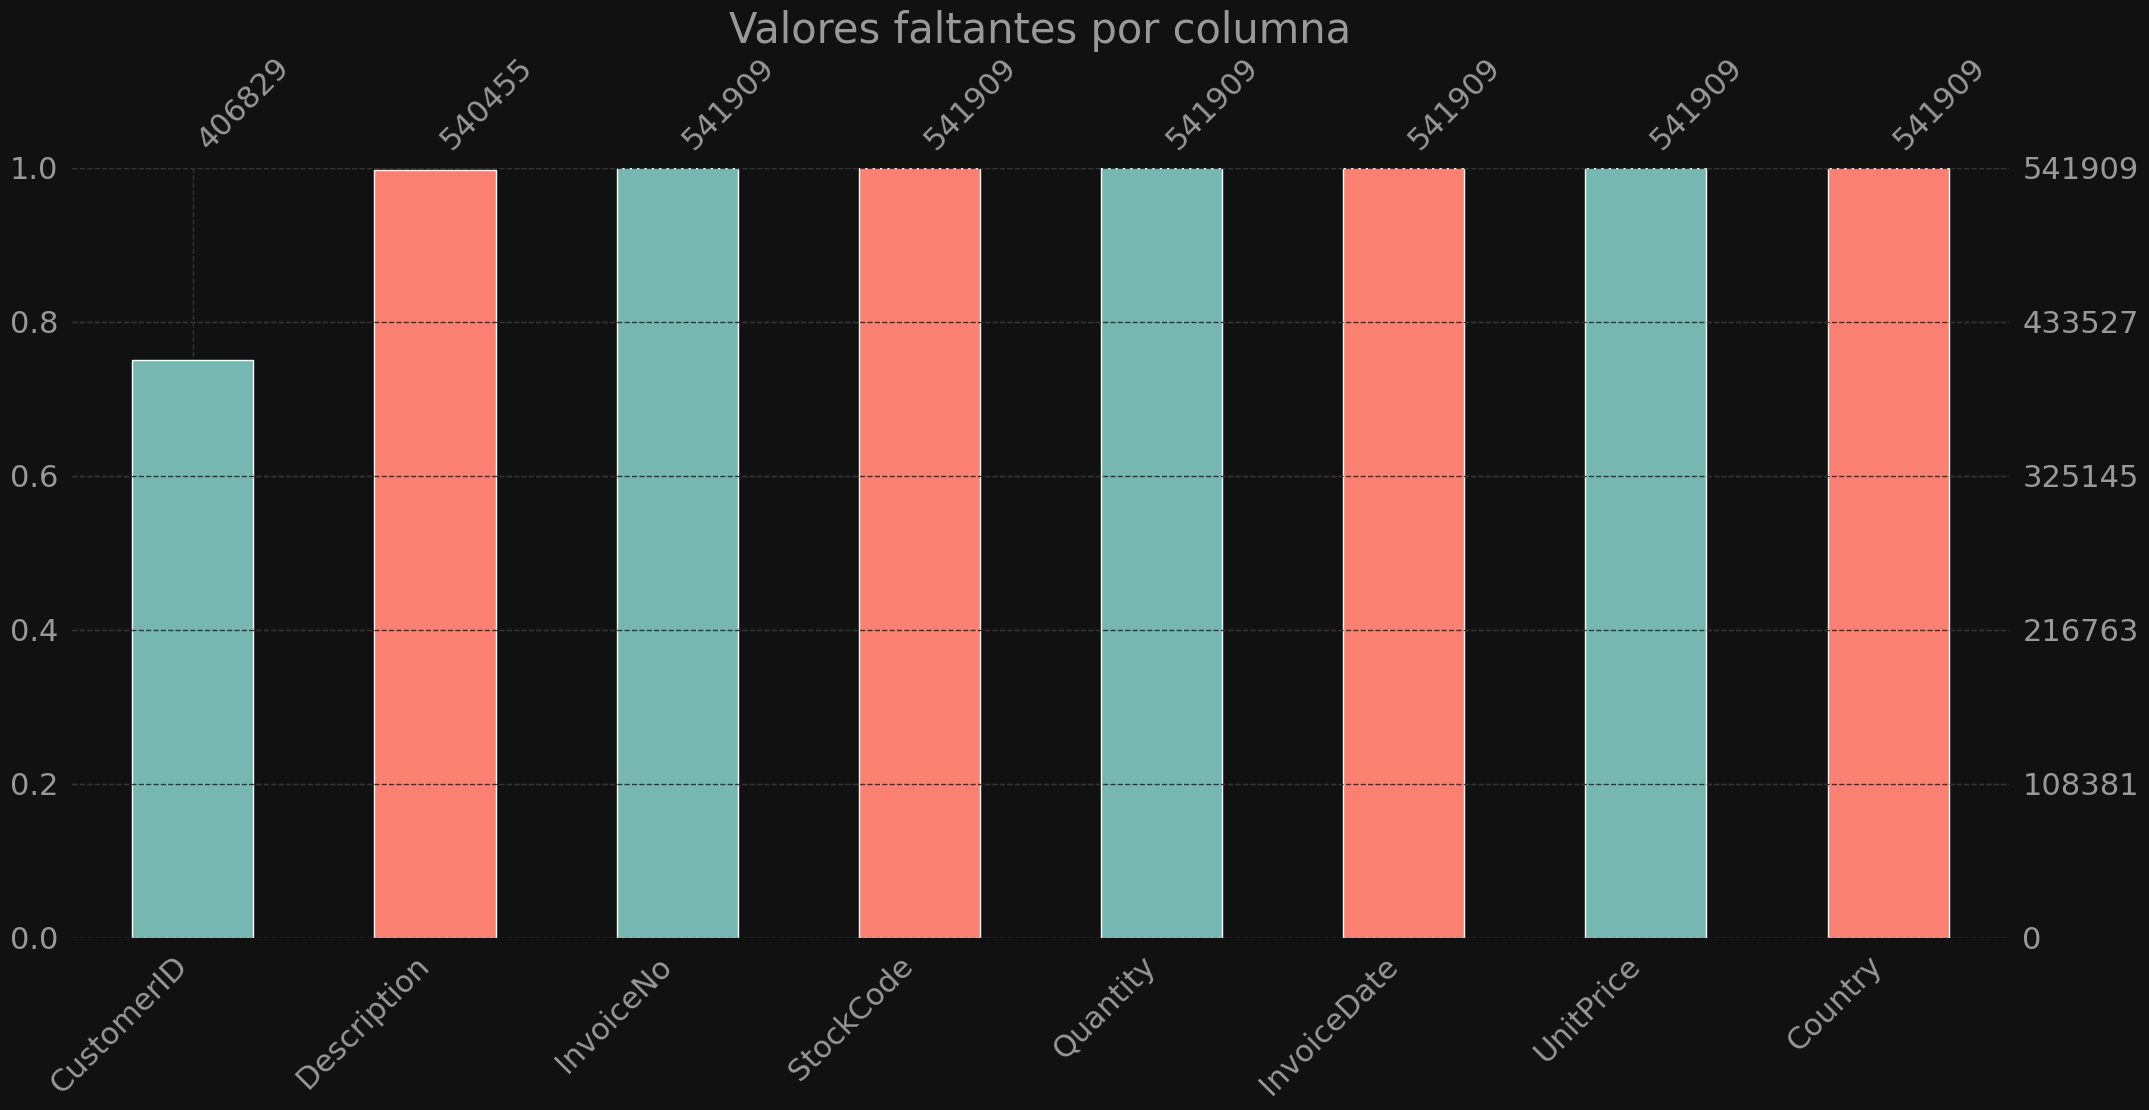

CustomerID     135080
Description      1454
dtype: int64


In [10]:
#grafico de Nan's
configuracion_grafico_missingno(my_data)

#lista de valores faltantes
print(my_data.isnull().sum().loc[lambda x: x>0].sort_values(ascending=False))


## Observaciones
* En total hay 541,909 filas con 8 columnas.
* La columna 'CustomerID' tiene 135,080 faltantes que equivalen al 24.9% del total.
* La columna 'Description' tiene 1,454 faltantes que equivalen al 0.27% del total.
* Hay 4 columnas tipo objeto que son: 'InvoiceNo', 'StockCode', 'Description', 'Country'.
* Hay 3 columnas tipo numericas, dos con decimales: 'UnitPrice', 'CustomerID' y uno entero: 'Quantity'.
* Hay una columna tipo datetime.
* Las fechas comenza desde 2010-12-01 08:26:00 hasta 2011-12-09 12:50:00.
* Tanto la columna 'UnitPrice' y 'Quantity tienen valores altos tanto positivos como negativos, lo cual pueda deberse a cancelaciones o errores. En cuanto a estos los eliminaremos considerando que son outliners, y lo haremos con quantiles.
* Tambien eliminaremos devoluciones o cancelaciones ya que este analisis es unicamente para ventas, y al manejar esos valores no podremos observar bien los que nos interesan.


# Limpieza e imputacion
1. creamos una nueva columna 'NewDescription' es la imputacion en la que va estar la descripcion que esta relaciona al codigo 'StockCode' por producto

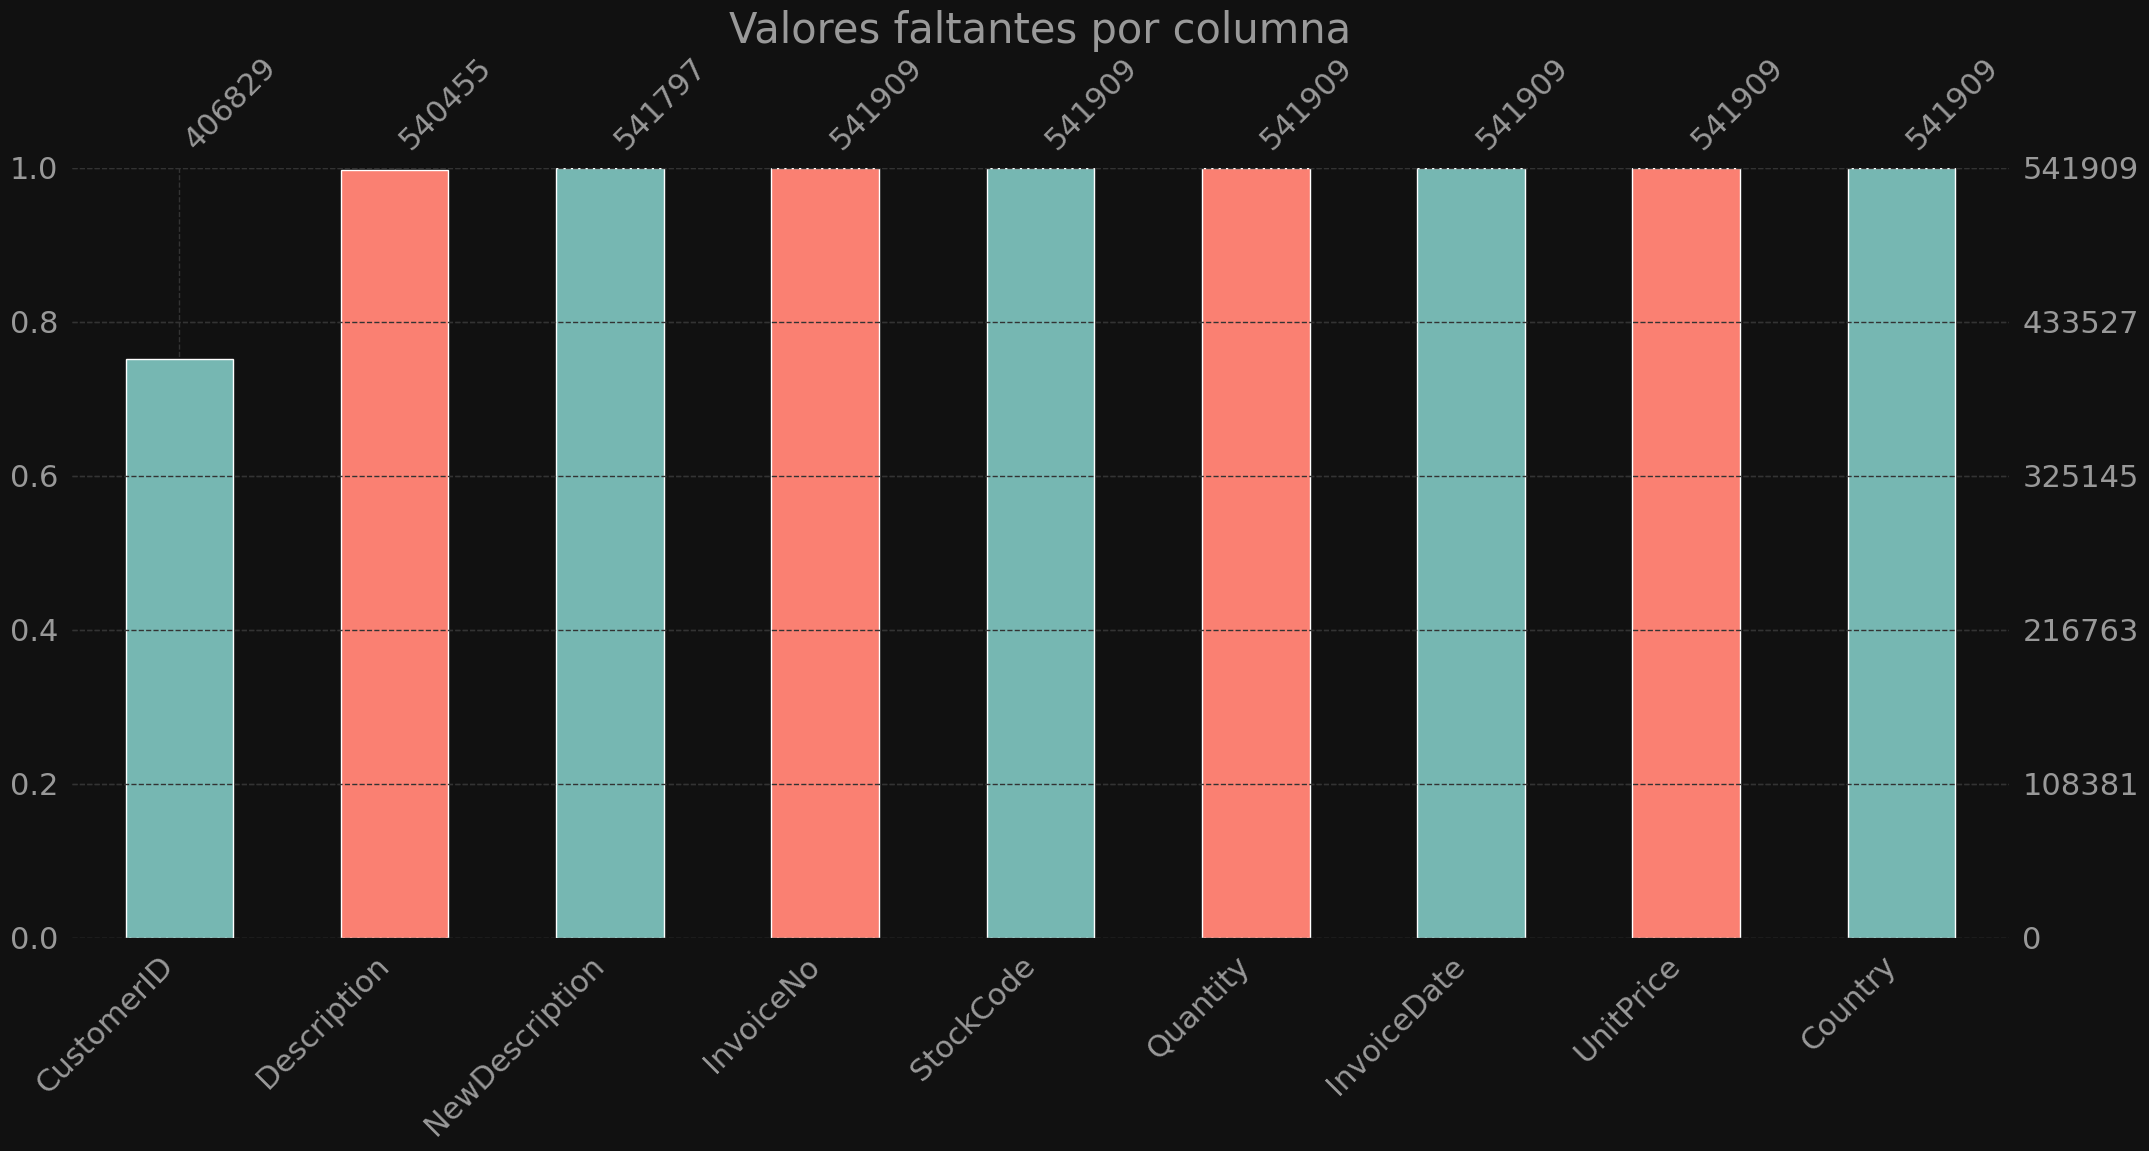

In [11]:
#creamos una copia para preservar las columnas originales
df_full = my_data.copy()

#Creamos un diccionario para despues implementar una nueva columna
descripcion_por_codigo = (
    df_full
    .dropna(subset=['Description'])
    .drop_duplicates(subset=['StockCode'])
    .set_index('StockCode')['Description']
    .to_dict()
)

# Creamos la columna 'NewDescription' 
df_full['NewDescription']=df_full['StockCode'].map(descripcion_por_codigo)

#grafico de Nan's actualizado con nueva columna
configuracion_grafico_missingno(df_full)

In [12]:
#lista de faltantes
print(df_full.isnull().sum().loc[lambda x: x>0].sort_values(ascending=False))

CustomerID        135080
Description         1454
NewDescription       112
dtype: int64


Con esta nueva columna logramos que pasara del **0.27%** de datos flatantes en 'Description' a solo el **0.02%** en 'NewDescription'

2. Al ser un valor tan bajo el porcentaje de 'NewDescription', procedemos a eliminar las filas donde esta columna tenga como valor el Nan.



In [13]:
df_full.dropna(subset=['NewDescription'], inplace=True)
print(df_full.isnull().sum().loc[lambda x: x>0].sort_values(ascending=False))


CustomerID     134968
Description      1342
dtype: int64


3. Ahora procedemos a eliminar los Nan's de la columna 'CustomerID', unicamente para el primer enfoque que es cliente.
   Para el enfoque 2 y 3 dejamos estas filas para no perder datos de ventas, que podrian llegar a ser importantes para el analisis centrado en geografia o tiempo.

Van a quedar dos DataFrames:
* df_enfoque_uno: Va a tener los Nan's de 'CustomerID' eliminados.
* df_full: En el que no van a aliminarse los Nan's de 'CustomerID', es para enfoque 2 y 3.

In [14]:
df_enfoque_uno = df_full.dropna(subset=['CustomerID']).copy()
df_enfoque_uno['CustomerID'] = df_enfoque_uno['CustomerID'].astype(int)

#Borramos 'Description', ya que ahora tenemos 'NewDescription'
df_full.drop('Description', axis=1, inplace=True)
df_enfoque_uno.drop('Description', axis=1, inplace=True)

#con esto vemos la sumatoria de nulos de los dos df
print(f'Df_full: \n{df_full.isnull().sum().loc[lambda x: x>0].sort_values(ascending=False)}')
print(f'Df_enfoque_uno: \n{df_enfoque_uno.isnull().sum().loc[lambda x: x>0].sort_values(ascending=False)}')



Df_full: 
CustomerID    134968
dtype: int64
Df_enfoque_uno: 
Series([], dtype: int64)


4. Ahora recordemos que nuestros df tienen cancelaciones que son indicadas con 'C' al iniciar el InvoiceNo, asi que los eliminamos:
* df_full_ventas: EL nuevo df de ventas sin cancelaciones se deja el df_full por si depues se desea hacer analisis de de cancelaciones.
* df_enfoque_uno = Tambien se quitan los que comienzan con 'C' para eliminar cancelaciones

In [15]:
# Unificando y asegurando que todas las 'C'sean mayusculas
df_full['InvoiceNo'] = df_full['InvoiceNo'].str.upper()
df_enfoque_uno['InvoiceNo'] = df_enfoque_uno['InvoiceNo'].str.upper()

df_full_ventas = df_full.copy()

# seleccionando solo las filas que no inicien con 'C'
df_full_ventas = df_full_ventas[~df_full_ventas['InvoiceNo'].str.startswith('C', na=False)].copy()
df_enfoque_uno = df_enfoque_uno[~df_enfoque_uno['InvoiceNo'].str.startswith('C', na=False)].copy()

# nos basamos en df_full para dejar preparado uno de solo cancelaciones
df_cancelaciones = df_full[df_full['InvoiceNo'].str.startswith('C', na=False)].copy()

print("Ventas sin cancelaciones:", len(df_full_ventas))
print("Enfoque 1 sin cancelaciones:", len(df_enfoque_uno))
print("Solo cancelaciones:", len(df_cancelaciones))


Ventas sin cancelaciones: 532509
Enfoque 1 sin cancelaciones: 397924
Solo cancelaciones: 9288


Datafremes:
*  df_enfoque_uno: Esta imputado para solo mostrar las filas que tienen id de cliente, ya que es lo que necesitamos en este enfoque
*  df_full_ventas: A diferencia del anterior tiene todos los clientes asi auqneu si valor sea un Nan. no tiene cancelaciones, para mantener el analisis solo en ventas
* df_cancelaciones: igual que el anterior pero solo tiene las filas de cancelaciones

5. Manejo de Outliers

5.1. Detectamos outliners con mayores a 0 para no incluir el 0.

In [16]:
# Elimina filas con Quantity menor o igual a 0
df_full_ventas = df_full_ventas[df_full_ventas['Quantity'] > 0].copy()
df_enfoque_uno = df_enfoque_uno[df_enfoque_uno['Quantity'] > 0].copy()

# Elimina filas con UnitPrice menor o igual a 0
df_full_ventas = df_full_ventas[df_full_ventas['UnitPrice'] > 0].copy()
df_enfoque_uno = df_enfoque_uno[df_enfoque_uno['UnitPrice'] > 0].copy()

5.2. Visualización de outliners

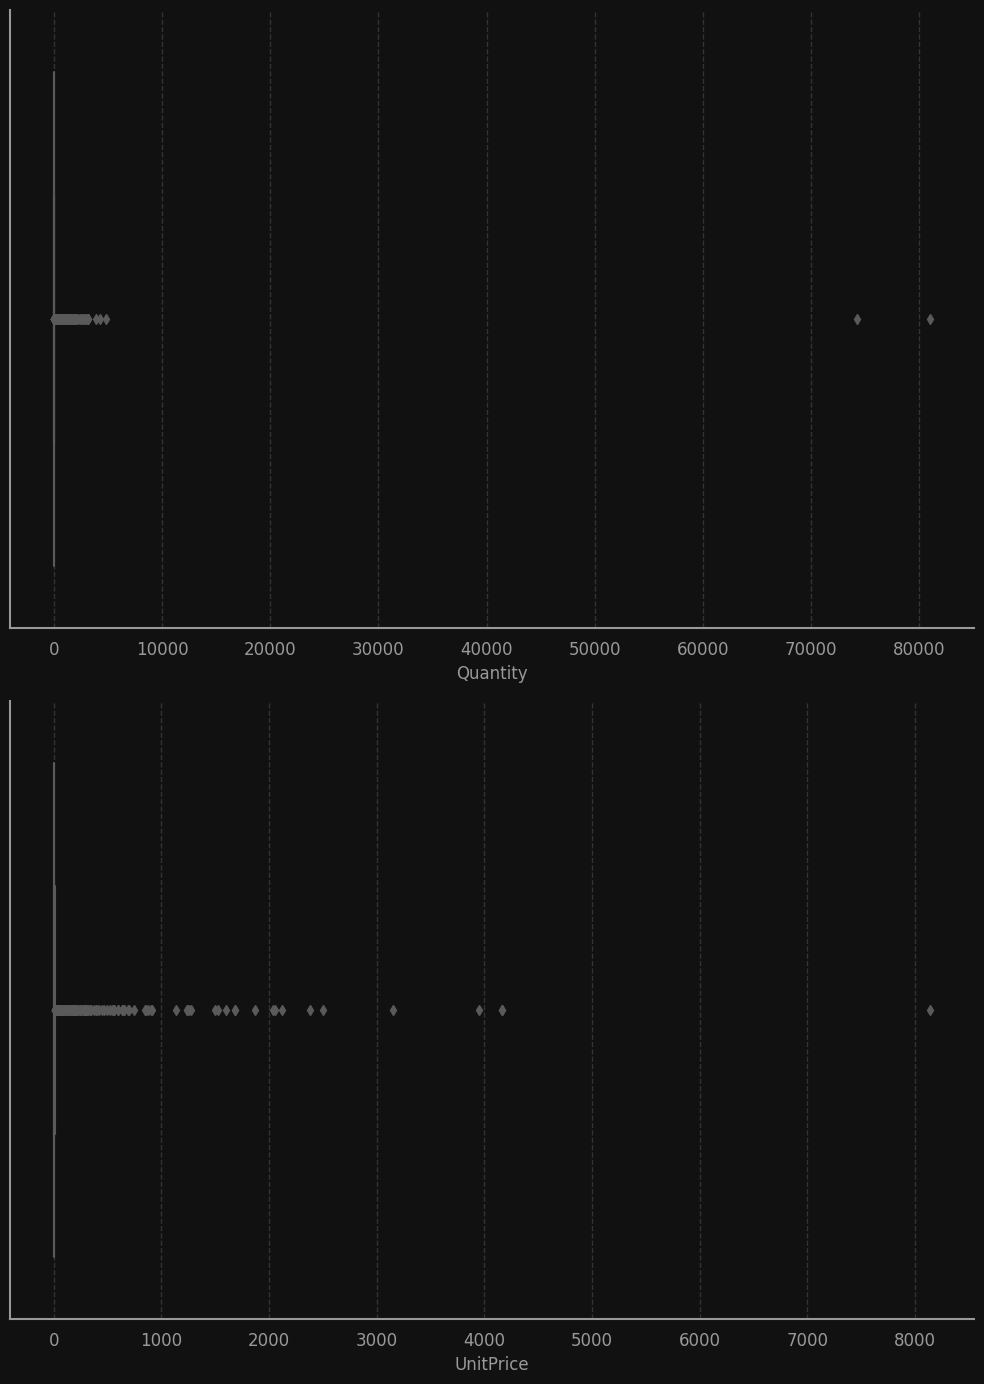

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 14))
sns.boxplot(x=df_enfoque_uno['Quantity'], ax=axes[0])
sns.boxplot(x=df_enfoque_uno['UnitPrice'], ax=axes[1])

plt.tight_layout()
plt.show()

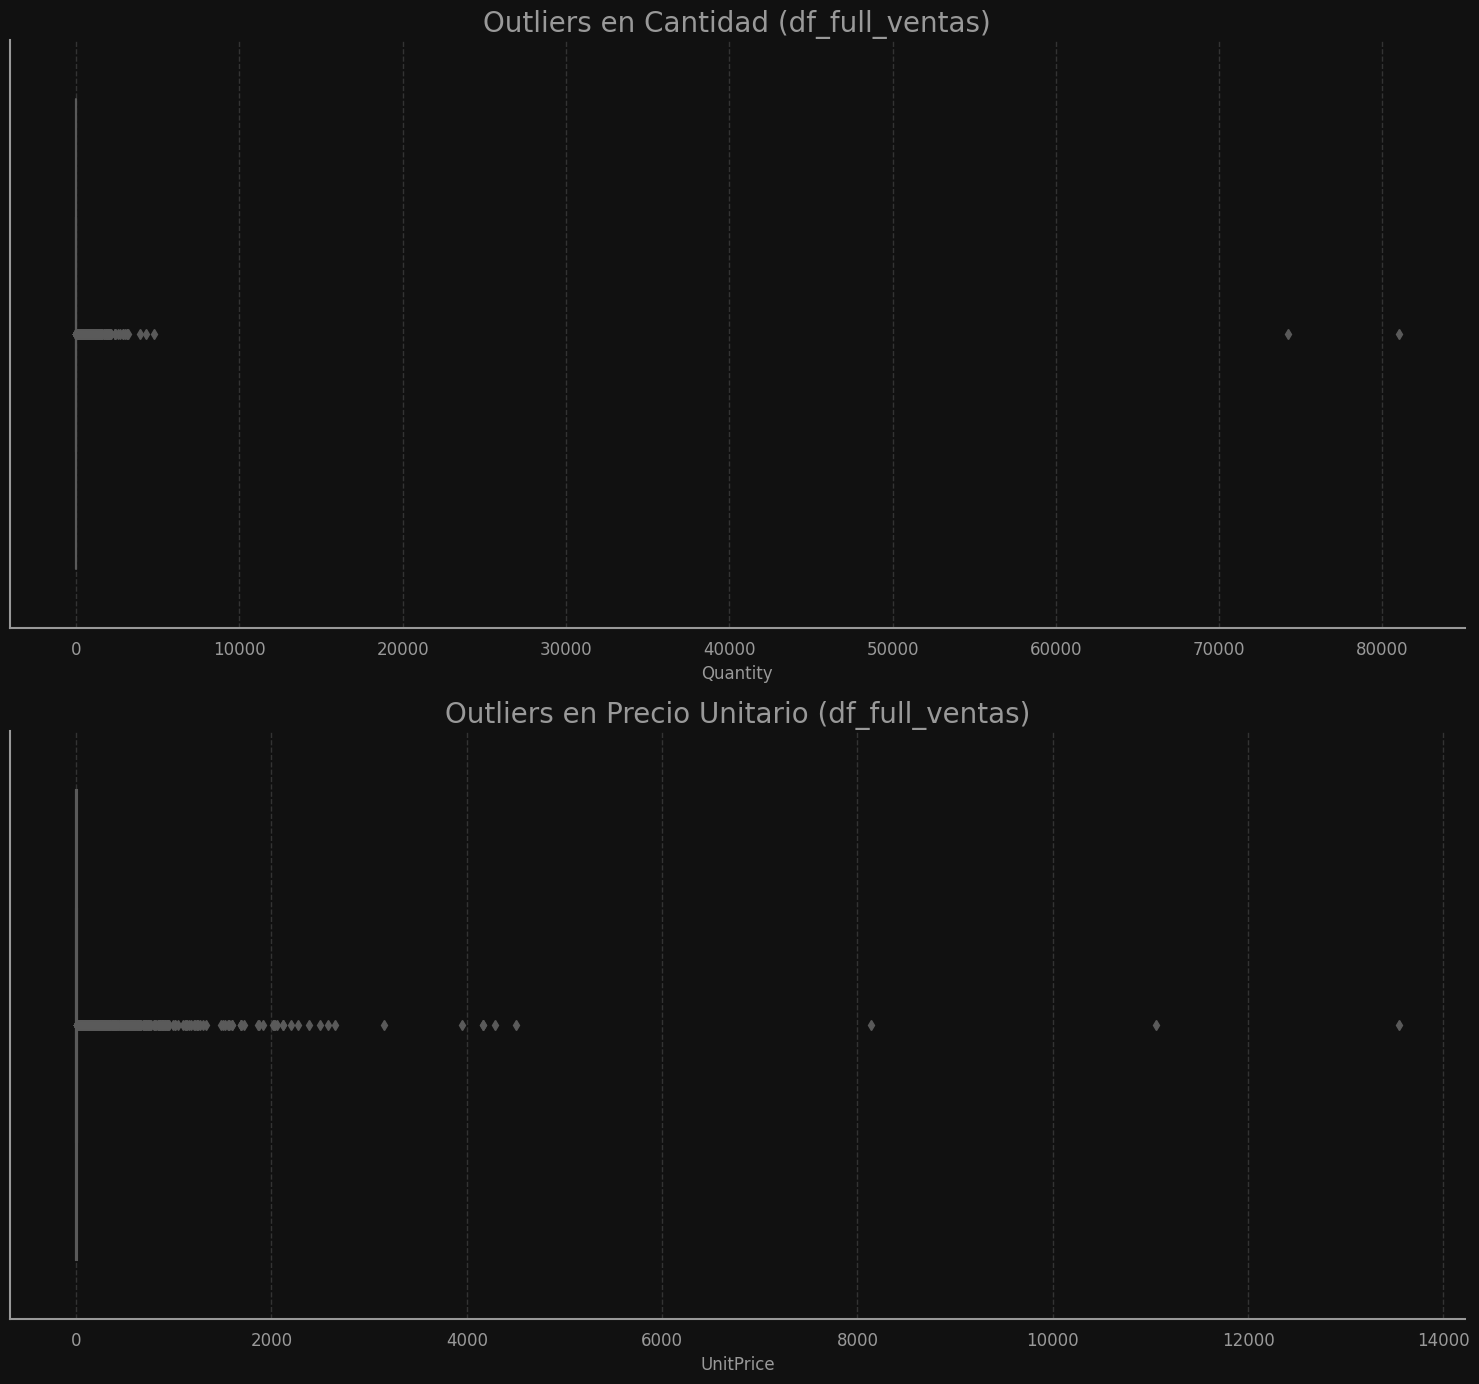

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(15, 14))

sns.boxplot(x=df_full_ventas['Quantity'], ax=axes[0])
axes[0].set_title('Outliers en Cantidad (df_full_ventas)')

sns.boxplot(x=df_full_ventas['UnitPrice'], ax=axes[1])
axes[1].set_title('Outliers en Precio Unitario (df_full_ventas)')

plt.tight_layout()
plt.show()

## Análisis de graficas:
vemos que auotliers muy grandes de muy pocos valores asi que hacemos un manejo valores atipicos, calculamos cuatiles y aplicamos IQR

In [19]:
q1_quan_ventas = df_full_ventas['Quantity'].quantile(0.25)
q3_quan_ventas = df_full_ventas['Quantity'].quantile(0.75)
iqr_quan_ventas = q3_quan_ventas - q1_quan_ventas
limite_superior_quan_ventas = q3_quan_ventas + 1.5 * iqr_quan_ventas
print('df_full_ventas para Quantity:')
print(f'Quantil 1 para "Quantity" 25%: {q1_quan_ventas}')
print(f'Quantil 3 para "Quantity" 75%: {q3_quan_ventas}')
print(f'Rango interCuantil: {iqr_quan_ventas}')
print(f'Limite Superior: {limite_superior_quan_ventas}')


q1_unit_ventas = df_full_ventas['UnitPrice'].quantile(0.25)
q3_unit_ventas = df_full_ventas['UnitPrice'].quantile(0.75)
iqr_unit_ventas = q3_unit_ventas - q1_unit_ventas
limite_superior_unit_ventas = q3_unit_ventas + 1.5 * iqr_unit_ventas
print('\ndf_full_ventas para UnitPrice:')
print(f'Quantil 1 para "Quantity" 25%: {q1_unit_ventas}')
print(f'Quantil 3 para "Quantity" 75%: {q3_unit_ventas}')
print(f'Rango intercuartil: {iqr_unit_ventas}')
print(f'Limite Superior: {limite_superior_unit_ventas}')


df_full_ventas para Quantity:
Quantil 1 para "Quantity" 25%: 1.0
Quantil 3 para "Quantity" 75%: 10.0
Rango interCuantil: 9.0
Limite Superior: 23.5

df_full_ventas para UnitPrice:
Quantil 1 para "Quantity" 25%: 1.25
Quantil 3 para "Quantity" 75%: 4.13
Rango intercuartil: 2.88
Limite Superior: 8.45


In [20]:
q1_quan_enfoque = df_enfoque_uno['Quantity'].quantile(0.25)
q3_quan_enfoque = df_enfoque_uno['Quantity'].quantile(0.75)
iqr_quan_enfoque = q3_quan_enfoque - q1_quan_enfoque
limite_superior_quan_enfoque = q3_quan_enfoque + 1.5 * iqr_quan_enfoque
print('df_enfoque_uno para Quantity:')
print(f'Quantil 1 para "Quantity" 25%: {q1_quan_enfoque}')
print(f'Quantil 3 para "Quantity" 75%: {q3_quan_enfoque}')
print(f'Rango interCuantil: {iqr_quan_enfoque}')
print(f'Limite Superior: {limite_superior_quan_enfoque}')

q1_unit_enfoque = df_enfoque_uno['UnitPrice'].quantile(0.25)
q3_unit_enfoque = df_enfoque_uno['UnitPrice'].quantile(0.75)
iqr_unit_enfoque = q3_unit_enfoque - q1_unit_enfoque
limite_superior_unit_enfoque = q3_unit_enfoque + 1.5 * iqr_unit_enfoque
print('\ndf_enfoque_uno para UnitPrice:')
print(f'Quantil 1 para "Quantity" 25%: {q1_unit_enfoque}')
print(f'Quantil 3 para "Quantity" 75%: {q3_unit_enfoque}')
print(f'Rango intercuartil: {iqr_unit_enfoque}')
print(f'Limite Superior: {limite_superior_unit_enfoque}')

df_enfoque_uno para Quantity:
Quantil 1 para "Quantity" 25%: 2.0
Quantil 3 para "Quantity" 75%: 12.0
Rango interCuantil: 10.0
Limite Superior: 27.0

df_enfoque_uno para UnitPrice:
Quantil 1 para "Quantity" 25%: 1.25
Quantil 3 para "Quantity" 75%: 3.75
Rango intercuartil: 2.5
Limite Superior: 7.5


In [21]:
print(f"Filas en df_full_ventas ANTES de la limpieza: {len(df_full_ventas)}")
df_full_ventas = df_full_ventas[(df_full_ventas['Quantity']<limite_superior_quan_ventas)&(df_full_ventas['UnitPrice']<limite_superior_unit_ventas)].copy()
print(f"Filas en df_full_ventas DESPUES de la limpieza: {len(df_full_ventas)}")

print(f"Filas en df_enfoque_uno ANTES de la limpieza: {len(df_enfoque_uno)}")
df_enfoque_uno = df_enfoque_uno[(df_enfoque_uno['Quantity']<limite_superior_quan_enfoque)&(df_enfoque_uno['UnitPrice']<limite_superior_unit_enfoque)].copy()
print(f"Filas en df_enfoque_uno DESPUES de la limpieza: {len(df_enfoque_uno)}")


Filas en df_full_ventas ANTES de la limpieza: 530104
Filas en df_full_ventas DESPUES de la limpieza: 436166
Filas en df_enfoque_uno ANTES de la limpieza: 397884
Filas en df_enfoque_uno DESPUES de la limpieza: 337527


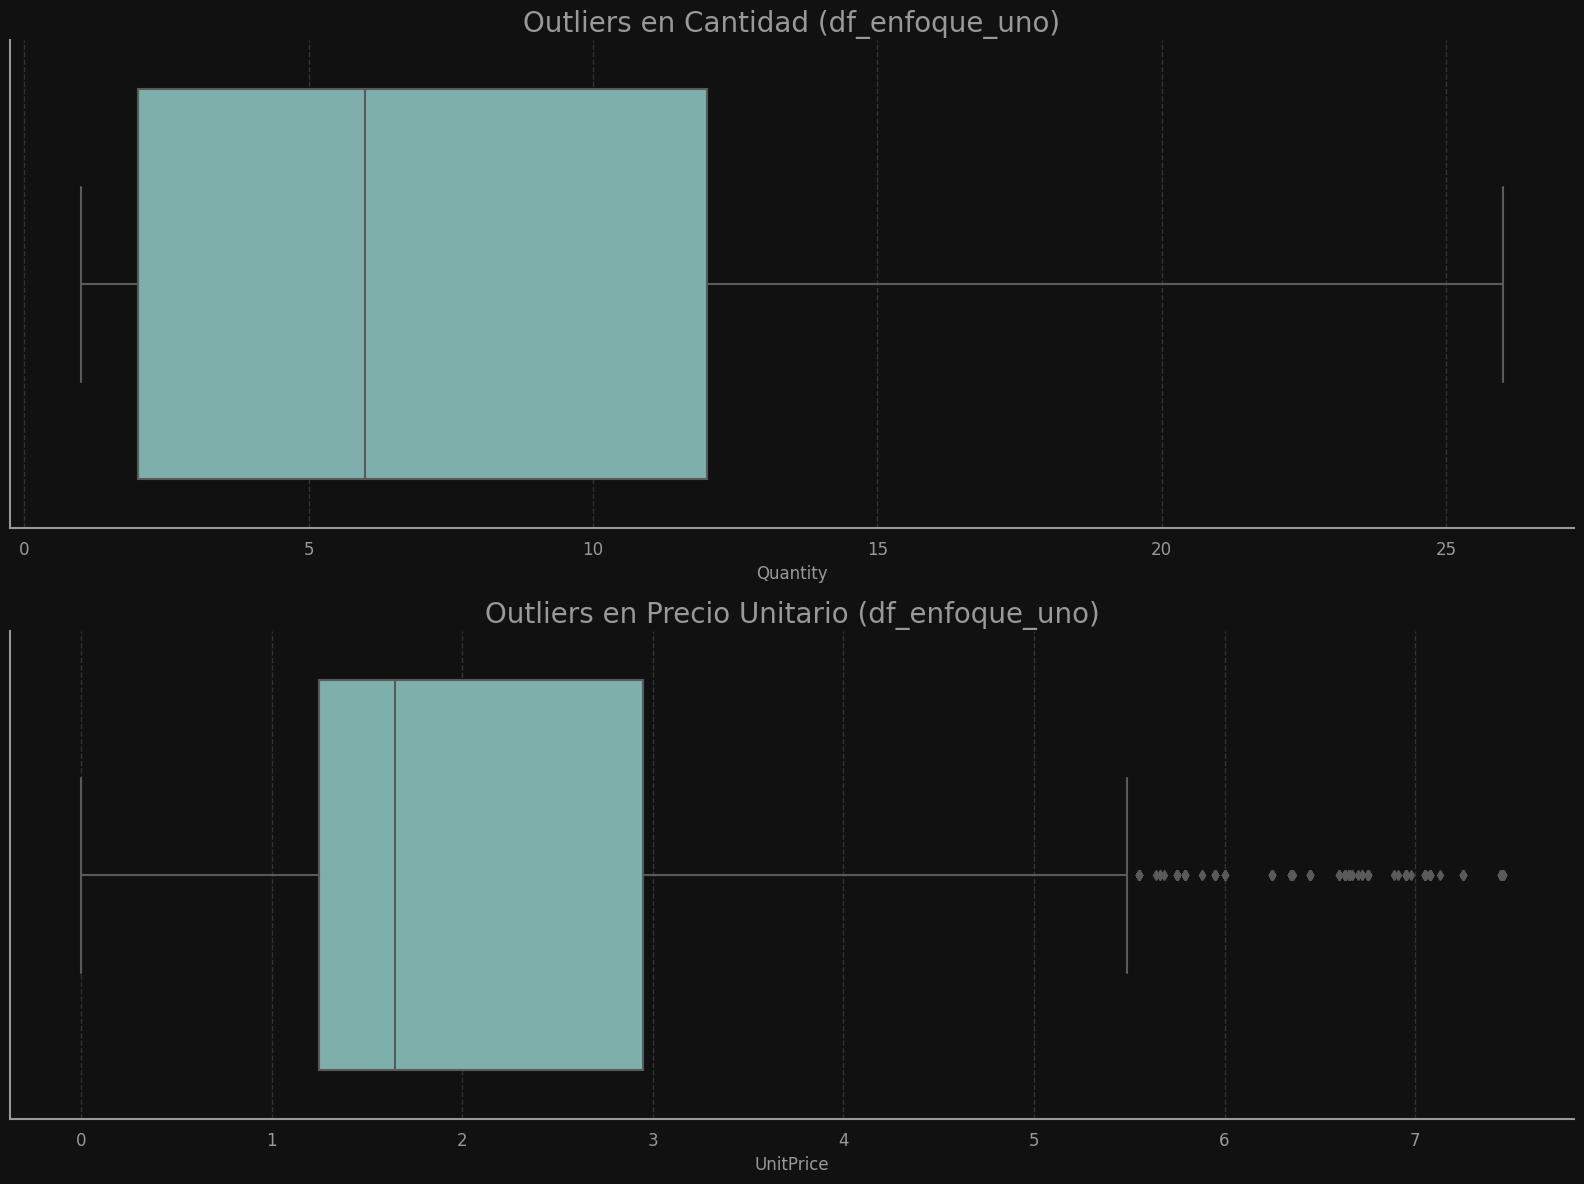

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(16,12))
sns.boxplot(x=df_enfoque_uno['Quantity'], ax=axes[0])
axes[0].set_title('Outliers en Cantidad (df_enfoque_uno)')

sns.boxplot(x=df_enfoque_uno['UnitPrice'], ax=axes[1])
axes[1].set_title('Outliers en Precio Unitario (df_enfoque_uno)')


plt.tight_layout()
plt.show()

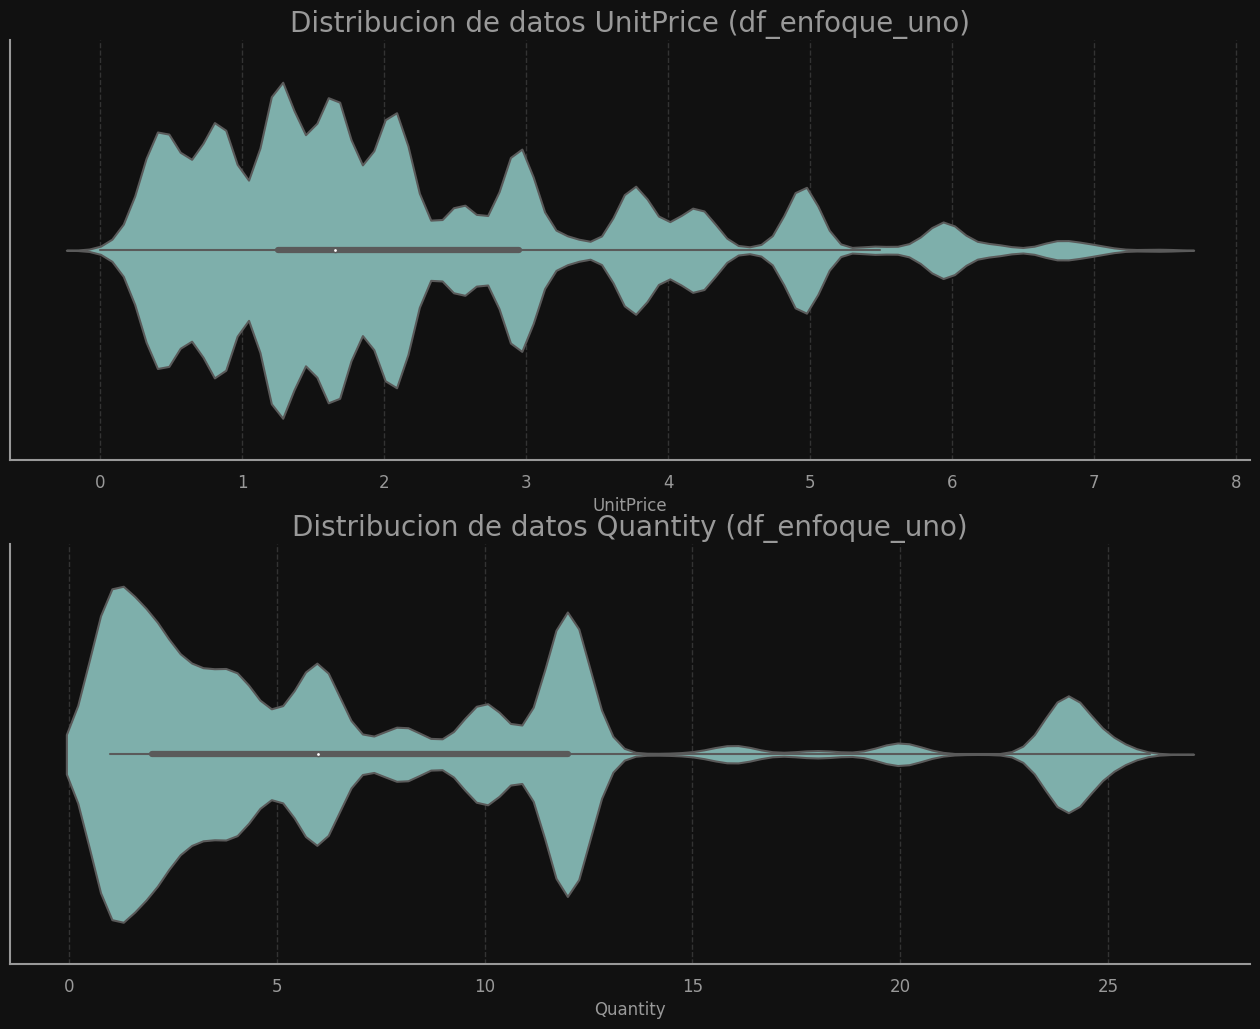

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(16,12))

sns.violinplot(data=df_enfoque_uno, x='UnitPrice', ax=axes[0])
axes[0].set_title('Distribucion de datos UnitPrice (df_enfoque_uno)')

sns.violinplot(data=df_enfoque_uno, x='Quantity', ax=axes[1])
axes[1].set_title('Distribucion de datos Quantity (df_enfoque_uno)')

plt.show()

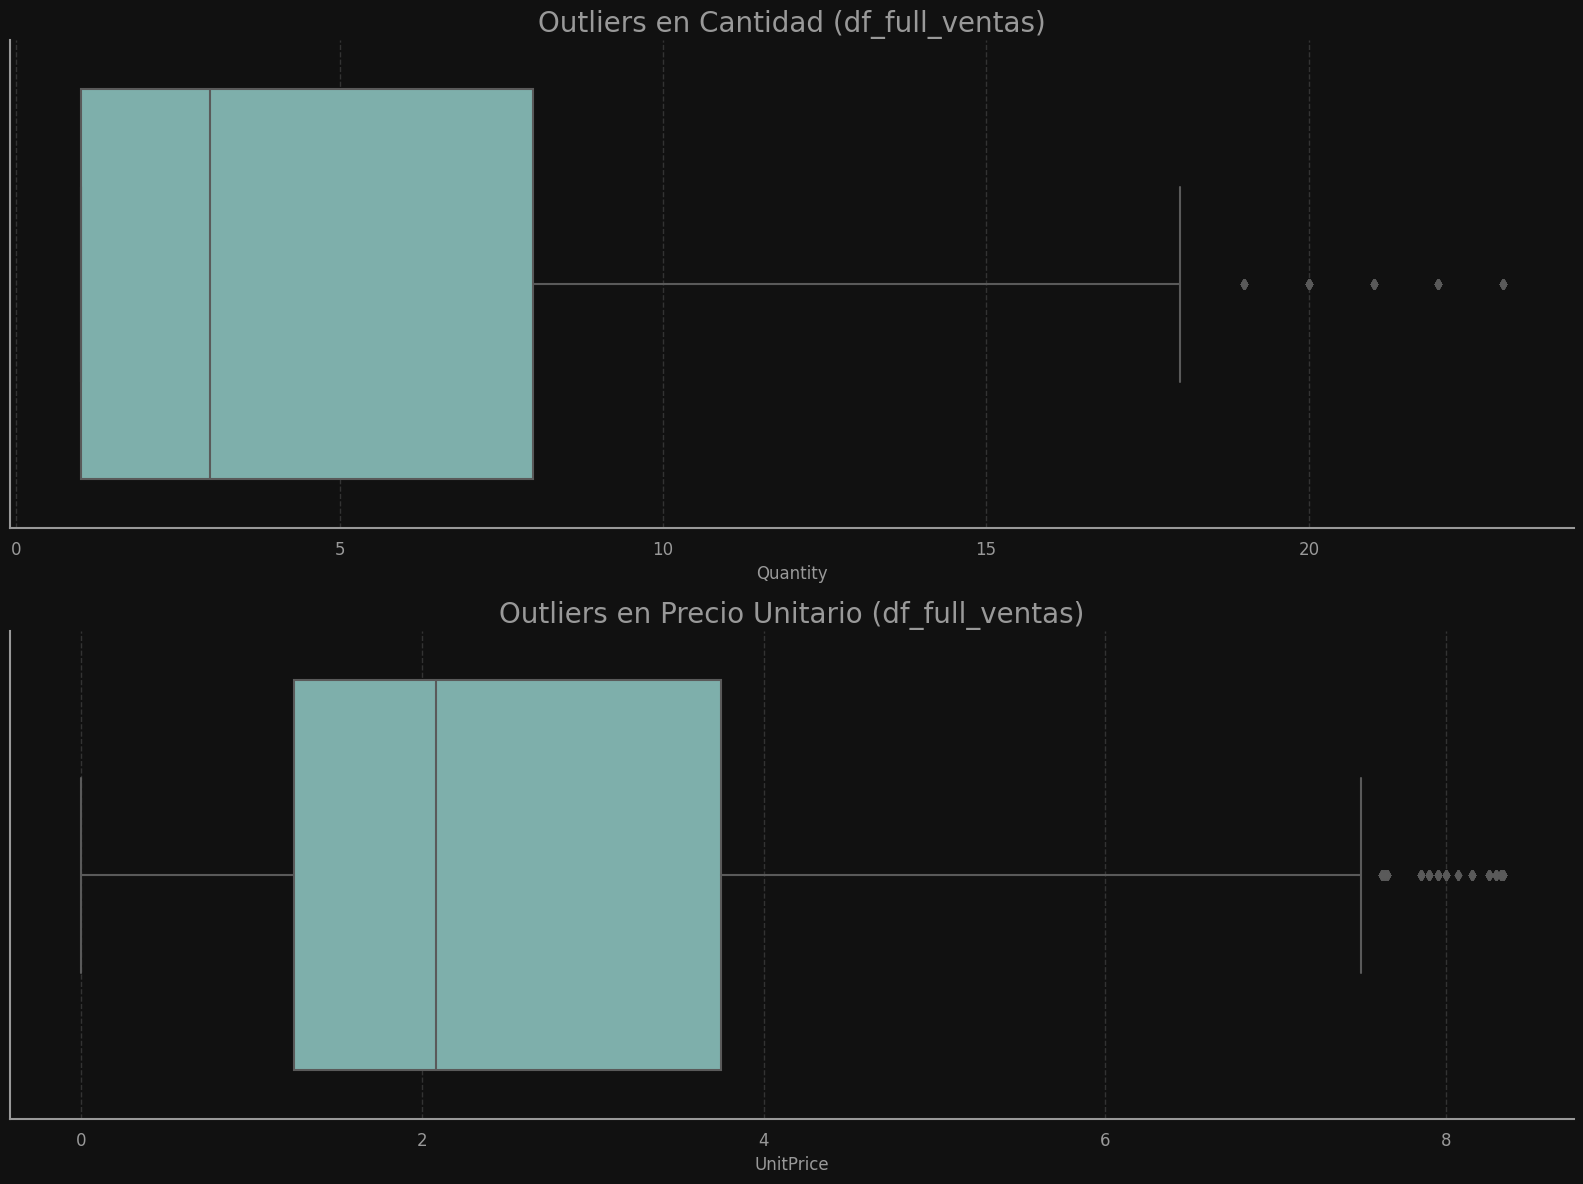

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

sns.boxplot(x=df_full_ventas['Quantity'], ax=axes[0])
axes[0].set_title('Outliers en Cantidad (df_full_ventas)')

sns.boxplot(x=df_full_ventas['UnitPrice'], ax=axes[1])
axes[1].set_title('Outliers en Precio Unitario (df_full_ventas)')

plt.tight_layout()
plt.show()

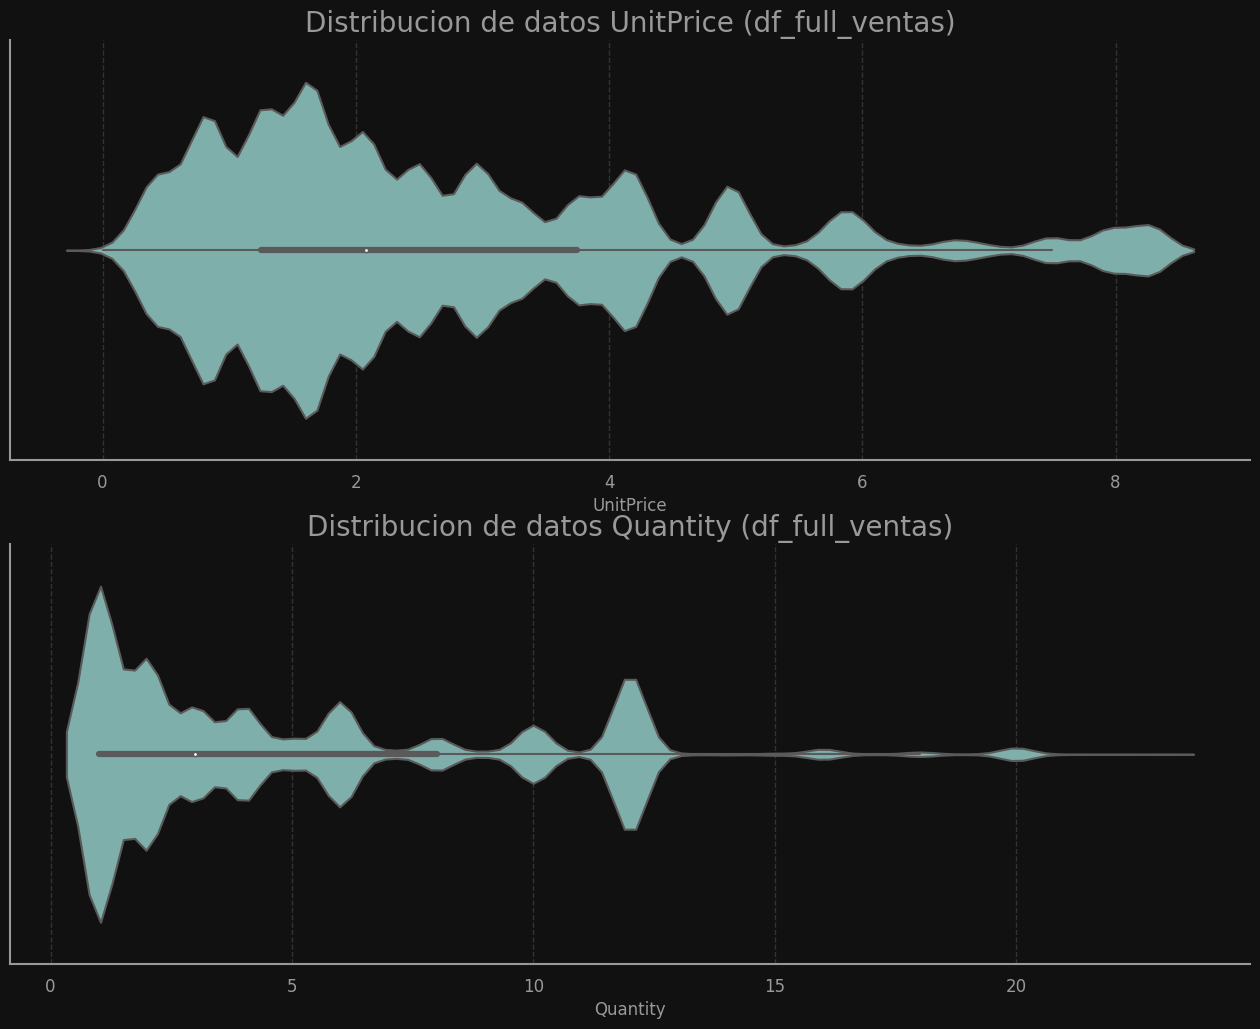

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(16,12))

sns.violinplot(data=df_full_ventas, x='UnitPrice', ax=axes[0])
axes[0].set_title('Distribucion de datos UnitPrice (df_full_ventas)')

sns.violinplot(data=df_full_ventas, x='Quantity', ax=axes[1])
axes[1].set_title('Distribucion de datos Quantity (df_full_ventas)')

plt.show()


> ***Nota: Dado que este proyecto se centra únicamente en un análisis exploratorio, no se han codificado las variables categóricas ni estandarizado las variables numéricas.En caso de una futura ampliación orientada a modelos predictivos, sería recomendable aplicar estos pasos según los requerimientos del algoritmo a utilizar.***


# Análisis

## Enfoque 1: Analisis de clientes RFM

Pregunta clave: ¿Quiénes son nuestros clientes más valiosos?

Análisis RFM (Recencia, Frecuencia, Valor Monetario): 

* Recencia (R): ¿Cuándo fue la última compra de un cliente?
* Frecuencia (F): ¿Con qué frecuencia compra un cliente?
* Valor Monetario (M): ¿Cuánto ha gastado en total un cliente?


Tambien aplicaremos un modelo de aprendizaje no supervisado como es el k-menas para poder segmentar los clientes.


1. Preparando datos para RFM

In [26]:
#tomamos una fecha de referencia, la cual es el dia despues del ultima fecha en 'InvoiceDate'
fecha_referencia = dt.datetime(2011, 12, 10)

# Agregamos una nueva caracteristica/columna
df_enfoque_uno['TotalPrice'] = df_enfoque_uno['Quantity']*df_enfoque_uno['UnitPrice']

In [27]:
# creamos df_rfm con una agrupacion por clientes 
df_rfm = df_enfoque_uno.groupby('CustomerID').agg(
    ultima_compra=('InvoiceDate', lambda x: (fecha_referencia - x.max()).days), 
    frecuencia=('InvoiceNo', pd.Series.nunique), 
    monetary=('TotalPrice', 'sum')
).reset_index()

In [28]:
print('Tabla del analisis de clinte:')
print(df_rfm.head(10))

Tabla del analisis de clinte:
   CustomerID  ultima_compra  frecuencia  monetary
0       12347              2           7   3314.73
1       12348            248           3     90.20
2       12349             18           1    984.15
3       12350            310           1    294.40
4       12352             36           7   1130.94
5       12353            204           1     29.30
6       12354            232           1    682.69
7       12355            214           1    219.00
8       12356            245           2   1086.56
9       12357             33           1   3195.41


In [29]:
print(df_rfm.describe())
print(df_rfm.corr())

         CustomerID  ultima_compra   frecuencia      monetary
count   4190.000000    4190.000000  4190.000000   4190.000000
mean   15290.868735      92.036038     4.014320   1027.460213
std     1719.261201      99.919315     7.015468   2195.775602
min    12347.000000       0.000000     1.000000      1.900000
25%    13809.250000      17.000000     1.000000    206.902500
50%    15280.500000      50.000000     2.000000    468.270000
75%    16770.750000     143.000000     4.000000   1135.425000
max    18287.000000     373.000000   196.000000  84673.780000
               CustomerID  ultima_compra  frecuencia  monetary
CustomerID       1.000000       0.001822   -0.012253 -0.050580
ultima_compra    0.001822       1.000000   -0.261597 -0.234719
frecuencia      -0.012253      -0.261597    1.000000  0.800166
monetary        -0.050580      -0.234719    0.800166  1.000000


In [30]:
#quitamos una advertencia que se da debido seaborn
warnings.filterwarnings('ignore', category=FutureWarning)

2. Distribucion de datos

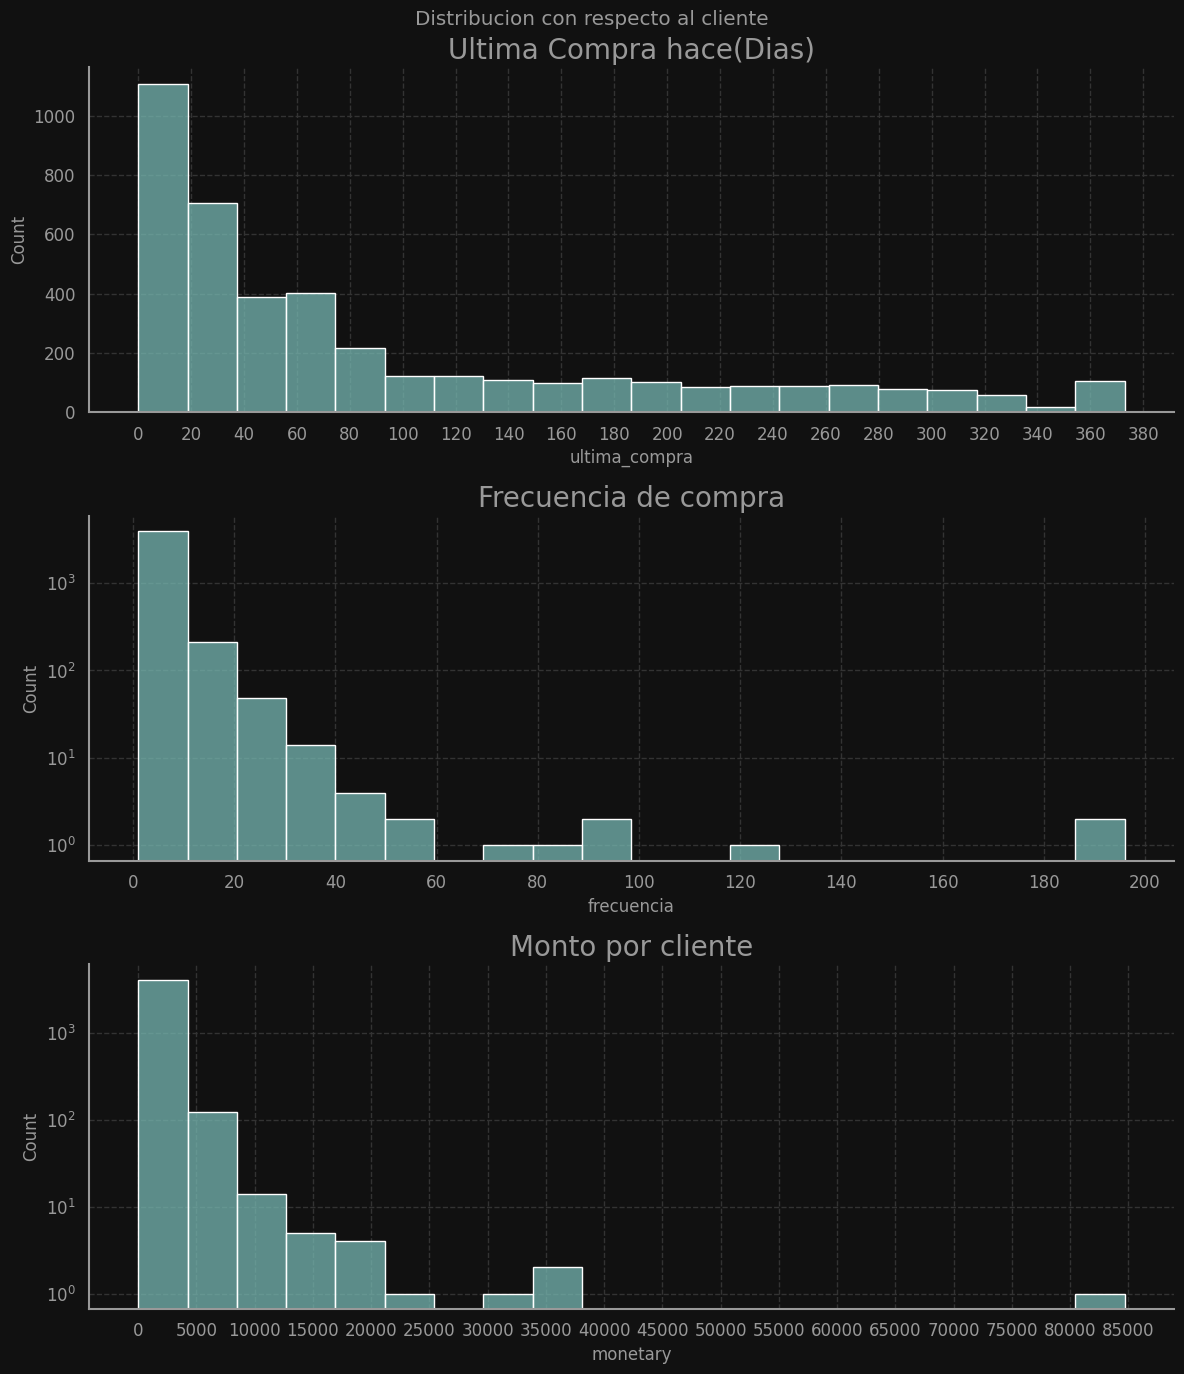

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('Distribucion con respecto al cliente')

sns.histplot(df_rfm['ultima_compra'], bins=20, ax=axes[0])
axes[0].set_title('Ultima Compra hace(Dias)')
axes[0].set_xticks(np.arange(0, df_rfm['ultima_compra'].max()+10, 20))


sns.histplot(df_rfm['frecuencia'], bins=20, ax=axes[1])
axes[1].set_title('Frecuencia de compra')
axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0, df_rfm['frecuencia'].max()+10, 20))

sns.histplot(df_rfm['monetary'], bins=20, ax=axes[2])
axes[2].set_title('Monto por cliente')
axes[2].set_yscale('log')
axes[2].set_xticks(np.arange(0, df_rfm['monetary'].max()+1000, 5000))

plt.tight_layout()
plt.show()

Ultima compra(Recencia): 
* En la primer grafica podemos ver cuando fue la ultima compra de cada cliente, segun la distribucion vemos que los ultmos 90 dias la actividad de clientes ha aumnetado.
* Podemos ver que una decerción de clientes que no han comprado en mas de 90 dias hata algunos llegar ha 370 dias. Puede deveerse a que sean compras ocacionales.

Frecuencia de compra(scala y en log, para una mejor apreciacion de distribución):
* Esta grafica vemos que la mayoria de clientes compra con una frecuencia menor 50 ocaciones.
* Muy pocos clientes compran mas de 60 veces.

Monto por cliente(scala y en log, para una mejor apreciacion de distribución):
* Esta grafica se parece mucho a la de frecuencia, asi que hay muy pocos clientes que hacen compras por un monto mayor 20.000 €, mientras que hay un cliente que ha hecho compras por mas 80.000 €.

3. Correlacion entre caracteristicas/columnas

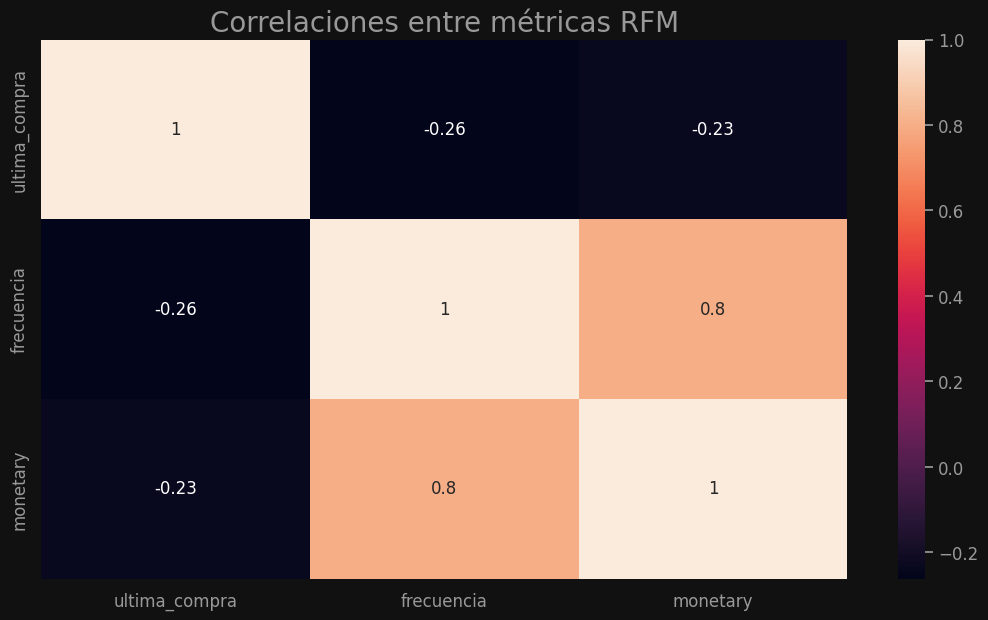

In [32]:
sns.heatmap(df_rfm[['ultima_compra', 'frecuencia', 'monetary']].corr(), annot=True)
plt.title('Correlaciones entre métricas RFM')
plt.show()

Vemos que hay una clara corelacion de frecuencia de compras y monto total de gasto por cliente.

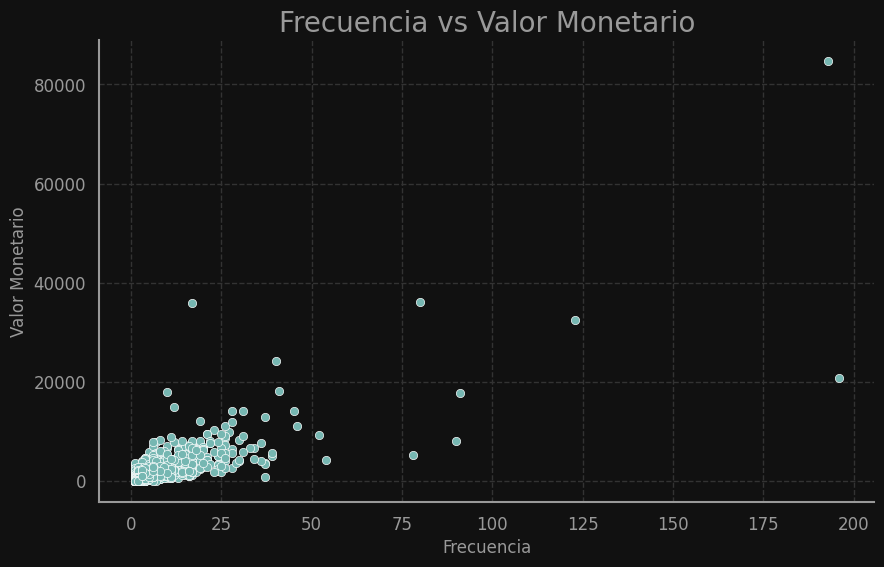

In [33]:
# Gráfico de dispersión para Frecuencia vs. Valor Monetario
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frecuencia', y='monetary', data=df_rfm)
plt.title('Frecuencia vs Valor Monetario')
plt.xlabel('Frecuencia')
plt.ylabel('Valor Monetario')
plt.show()

A mayor frecuencia los clientes suelen gastar mas o acumular mas gastos.

4. Ahora procedemos a segmentar las clases de clientes, asi que primero normalizamos valores y estandarizamos para poder usar un aprendizaje no supervisado como lo es el K-Means.

In [34]:
df_log = df_rfm.copy()
df_log['ultima_compra'] = np.log1p(df_log['ultima_compra'])
df_log['frecuencia'] = np.log1p(df_log['frecuencia'])
df_log['monetary'] = np.log1p(df_log['monetary'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log[['ultima_compra', 'frecuencia', 'monetary']])


> A cada columna a utilizar se le aplico np.log1p para estabilizar valores y mejorar el desempeño de K-Means. Aun asi se van a mostrar tambien los valores originales con sus clusters.

Antes de decidir la cantidad de segmentaciones(n_cluesters), haremos varias prueba para ver cual valor es el mas adecuado. 

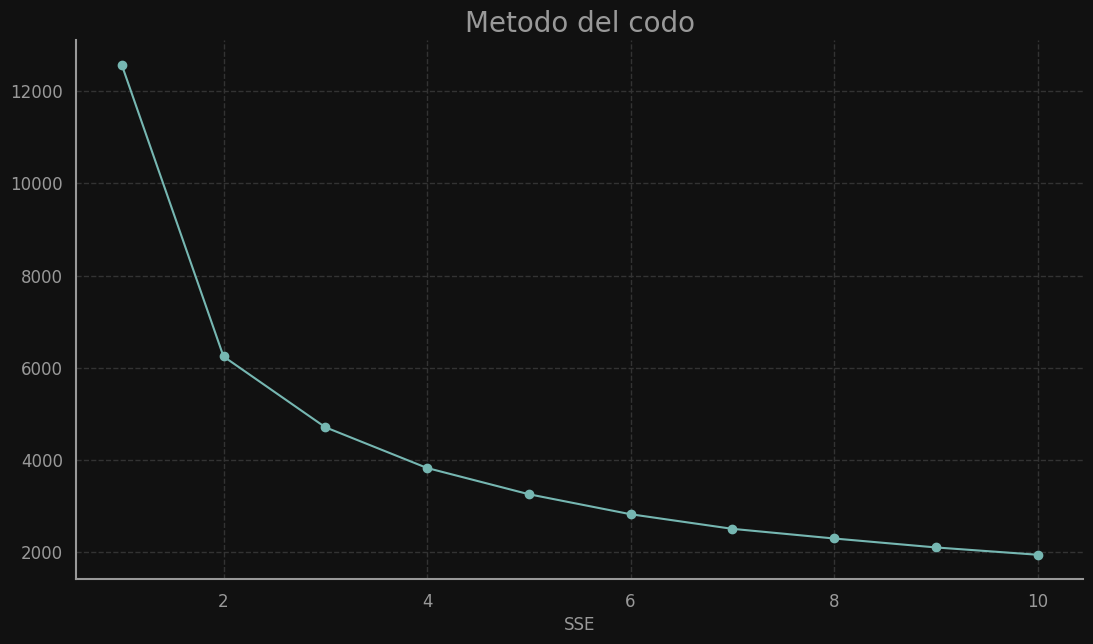

In [35]:
sse = []
k_range =range(1, 11)

for k in k_range:
    kmeans= KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Numero de clusters')
plt.xlabel('SSE')
plt.title('Metodo del codo')
plt.show()


A partir de 2 en el eje de SSE cambia la inlinacion de la grafica, por lo que segun esta validacion se recomienda usar 2.

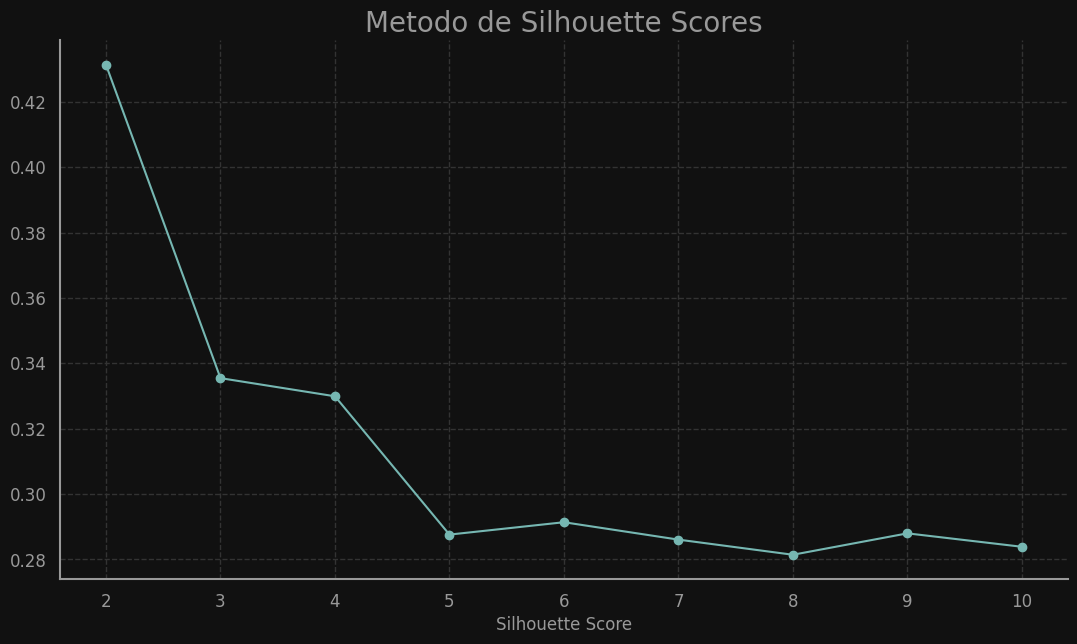

In [36]:
silhouette_scores = []
k_range_sil = range(2, 11)

for k in k_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.plot(k_range_sil, silhouette_scores, marker='o')
plt.xlabel('Numero de clusters')
plt.xlabel('Silhouette Score')
plt.title('Metodo de Silhouette Scores')
plt.show()



Esta validacion el 2(en el eje x) es el que mas cerca esta de 1 en el eje y. Por lo que se vuelve a recomendar utilizar el 2.

Hacemos una comprobacion con 2 y otros valores cercanos por si se puede llegar a permitir una mayor segmentación.

In [37]:
resultados = []

for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    resultados.append({
        'k': k,
        'SSE': kmeans.inertia_,
        'Silhouette': silhouette_score(X_scaled, labels),
        'Davies': davies_bouldin_score(X_scaled, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X_scaled, labels)
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


   k          SSE  Silhouette    Davies  Calinski-Harabasz
0  2  6245.356397    0.431369  0.890894        4241.185912
1  3  4711.373933    0.335481  1.047162        3492.008492
2  4  3827.738072    0.329927  1.031067        3186.883007
3  5  3258.637399    0.287607  1.066117        2989.618438


El 2 es el que da mejor en todo, asi que tomaremos ese. si se quisiera segmentar un poc mas pordriamos lleagr a tomar el 3 u 4. 

In [38]:
kmeans= KMeans(n_clusters=2, random_state=42)
df_log['cluster']=kmeans.fit_predict(X_scaled)

clusterss = df_log.groupby('cluster')[['ultima_compra', 'frecuencia', 'monetary']].mean()
print(clusterss)
clusterss_original=np.expm1(clusterss)
print(clusterss_original)

         ultima_compra  frecuencia  monetary
cluster                                     
0             4.491644    0.914446  5.453849
1             2.723108    1.959582  7.303104
         ultima_compra  frecuencia     monetary
cluster                                        
0            88.268109    1.495393   232.655884
1            14.227582    6.096358  1483.901357


El resultado anterior nos da el promedio de cada cluster para cada caracteristica, primero en los datos en su forma logaritmica y luego en sus valores reales.

En las siguientes celdas podemos ver la relacion entre caracteristicas y el sitograma de cada una con los datos fd_log y separada, por los 2 clusters que quedaron.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_36/2280479070.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


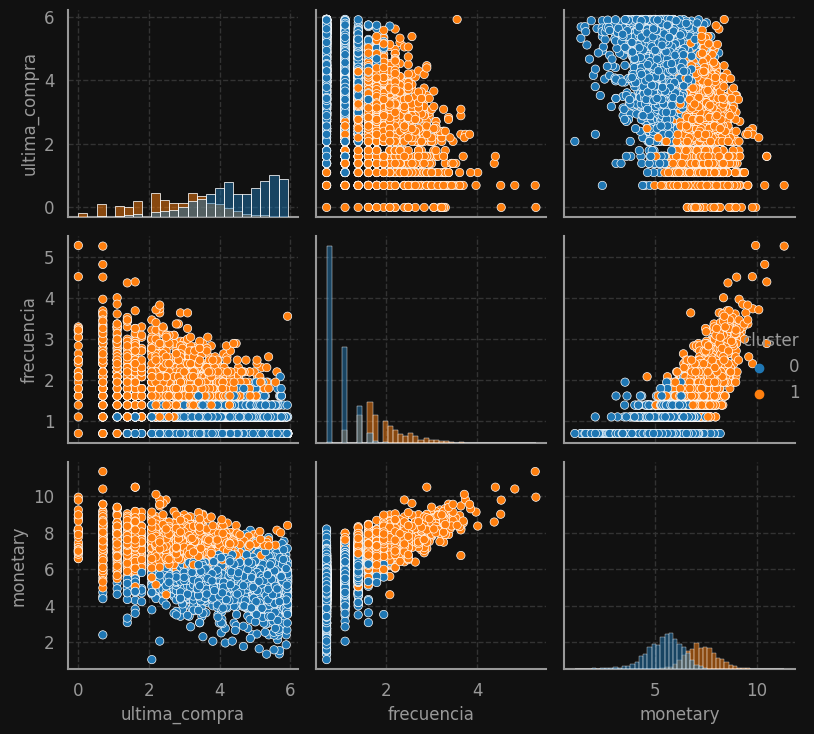

In [39]:
# Pairplot coloreado por cluster
sns.pairplot(df_log[['ultima_compra', 'frecuencia', 'monetary', 'cluster']], hue='cluster', diag_kind='hist', palette='tab10')
plt.tight_layout()
plt.show()

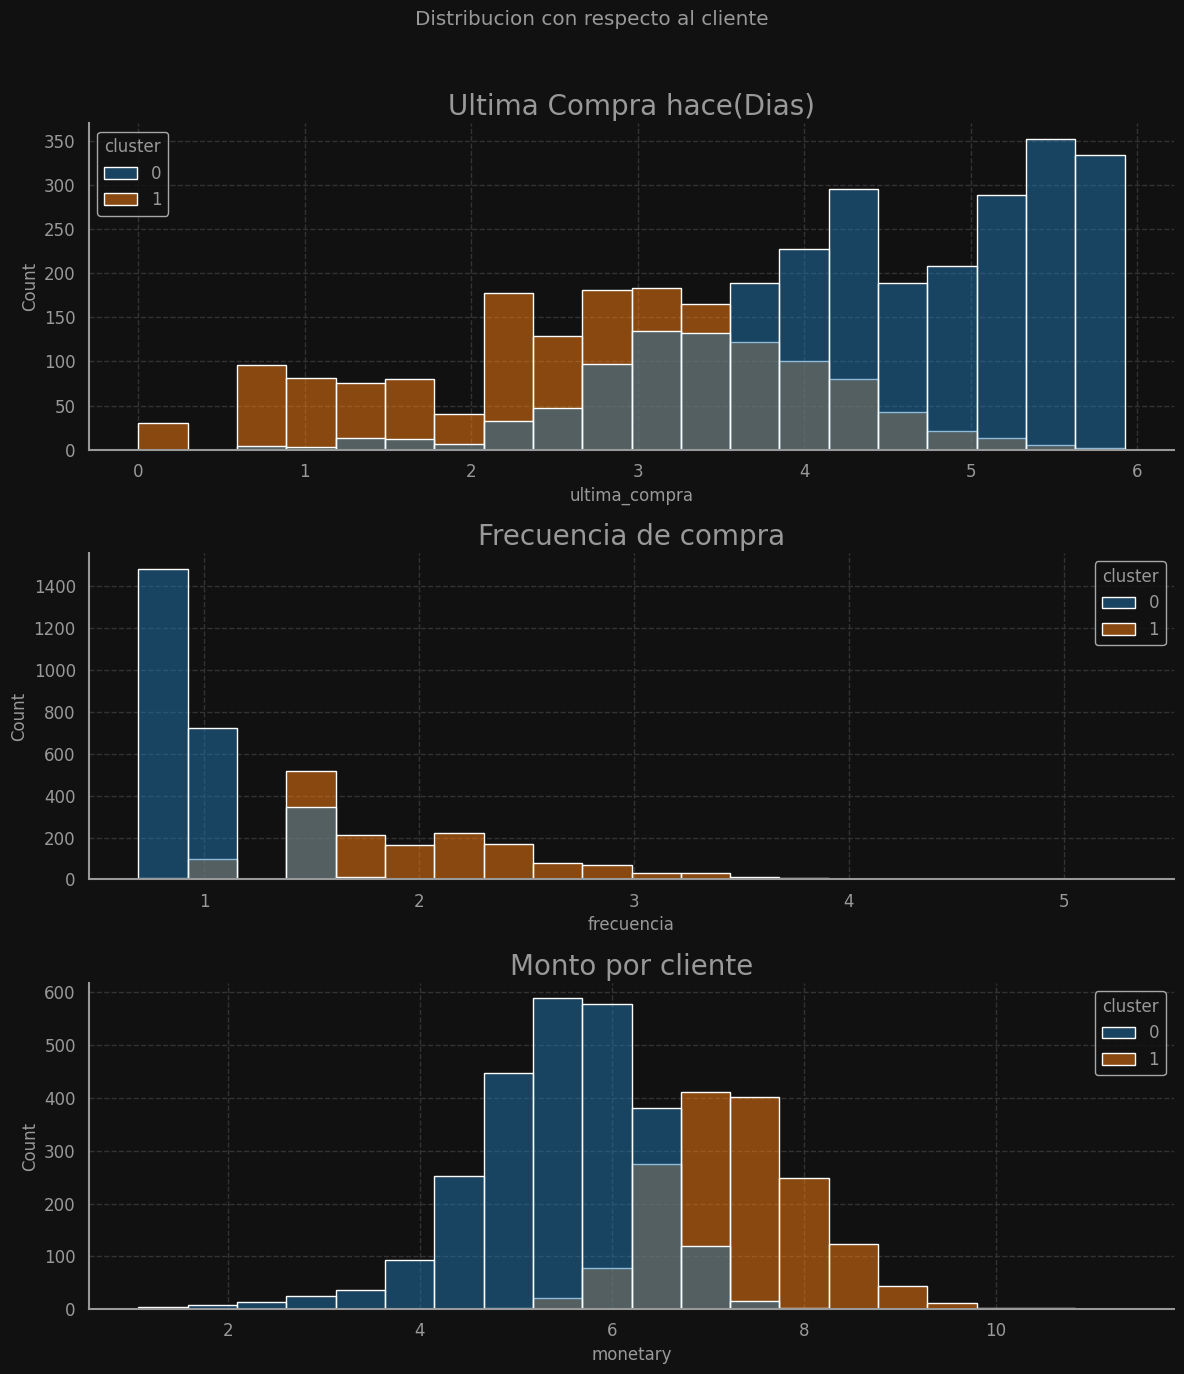

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('Distribucion con respecto al cliente')

sns.histplot(data=df_log, x='ultima_compra', bins=20, ax=axes[0], hue='cluster', palette='tab10')
axes[0].set_title('Ultima Compra hace(Dias)')
#axes[0].set_xticks(np.arange(0, df_rfm['ultima_compra'].max()+10, 20))


sns.histplot(data=df_log, x='frecuencia', bins=20, ax=axes[1], hue='cluster', palette='tab10')
axes[1].set_title('Frecuencia de compra')
#axes[1].set_yscale('log')
#axes[1].set_xticks(np.arange(0, df_rfm['frecuencia'].max()+10, 20))

sns.histplot(data=df_log, x='monetary', bins=20, ax=axes[2],  hue='cluster', palette='tab10')
axes[2].set_title('Monto por cliente')
#axes[2].set_yscale('log')
#axes[2].set_xticks(np.arange(0, df_rfm['Monetary'].max()+1000, 5000))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [41]:
df_rfm['cluster'] = df_log['cluster']

Las siguiente graficas son lo mismo que lo anterior pero sin aplicar log a los datos es decir con los datos originales con sus respectivas proporciones.

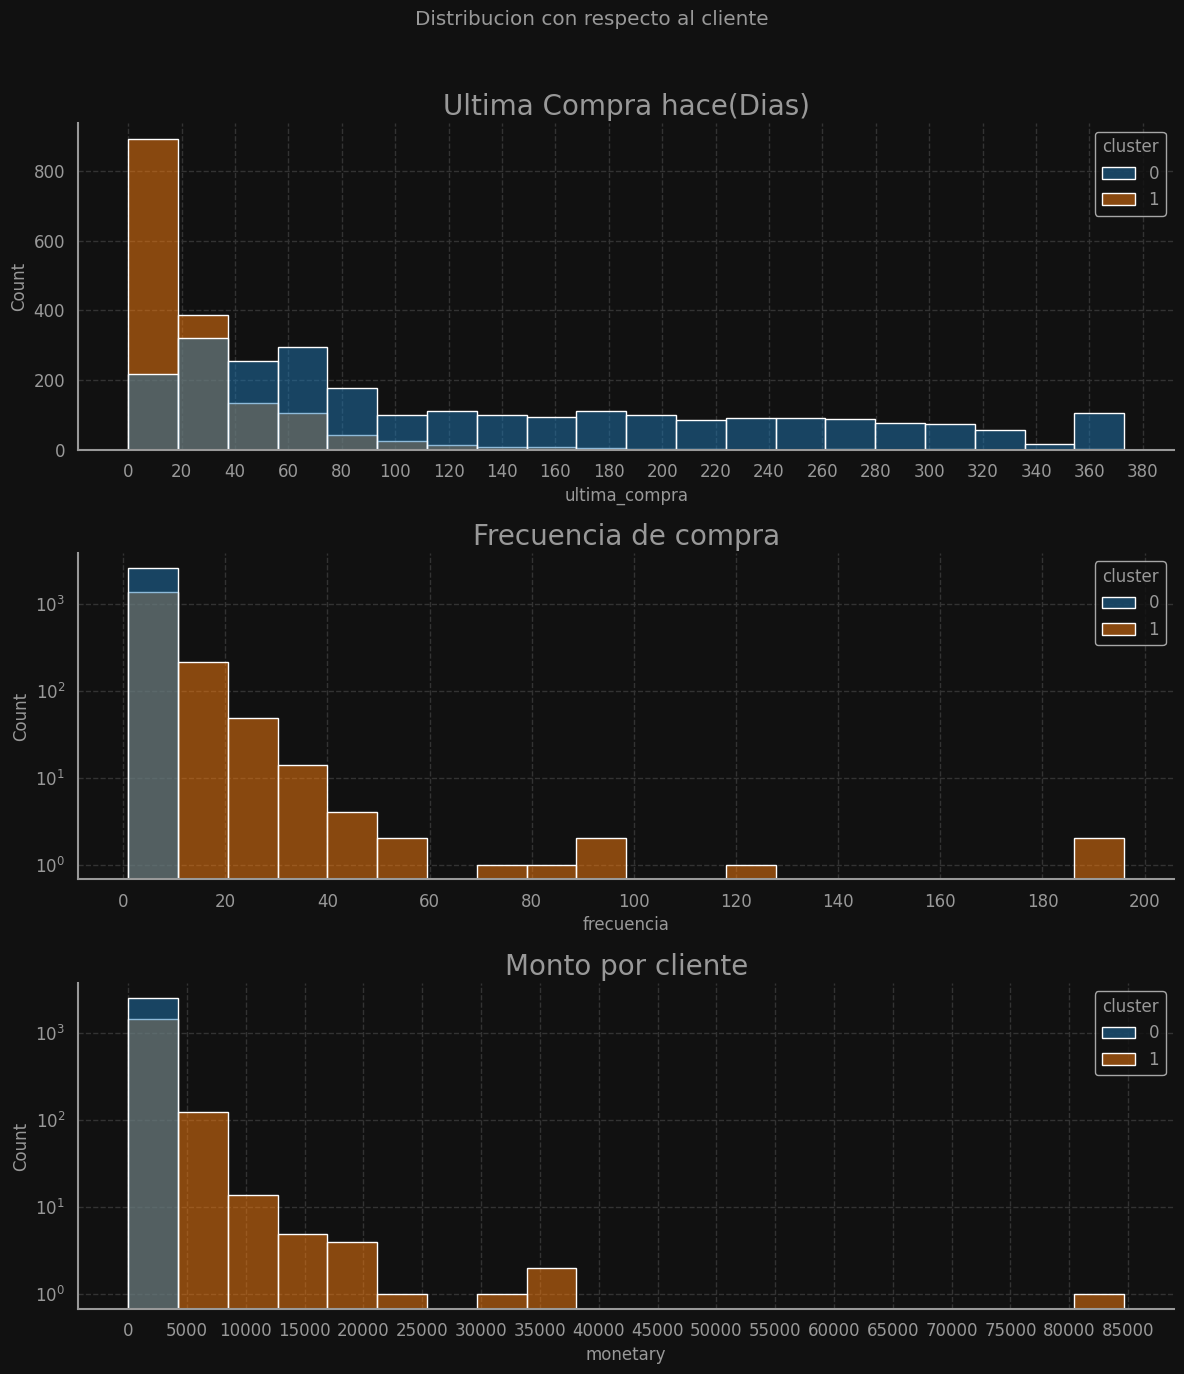

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('Distribucion con respecto al cliente')

sns.histplot(data=df_rfm, x='ultima_compra', bins=20, ax=axes[0], hue='cluster', palette='tab10')
axes[0].set_title('Ultima Compra hace(Dias)')
axes[0].set_xticks(np.arange(0, df_rfm['ultima_compra'].max()+10, 20))


sns.histplot(data=df_rfm, x='frecuencia', bins=20, ax=axes[1], hue='cluster', palette='tab10')
axes[1].set_title('Frecuencia de compra')
axes[1].set_yscale('log')
axes[1].set_xticks(np.arange(0, df_rfm['frecuencia'].max()+10, 20))

sns.histplot(data=df_rfm, x='monetary', bins=20, ax=axes[2],  hue='cluster', palette='tab10')
axes[2].set_title('Monto por cliente')
axes[2].set_yscale('log')
axes[2].set_xticks(np.arange(0, df_rfm['monetary'].max()+1000, 5000))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_36/1166118631.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


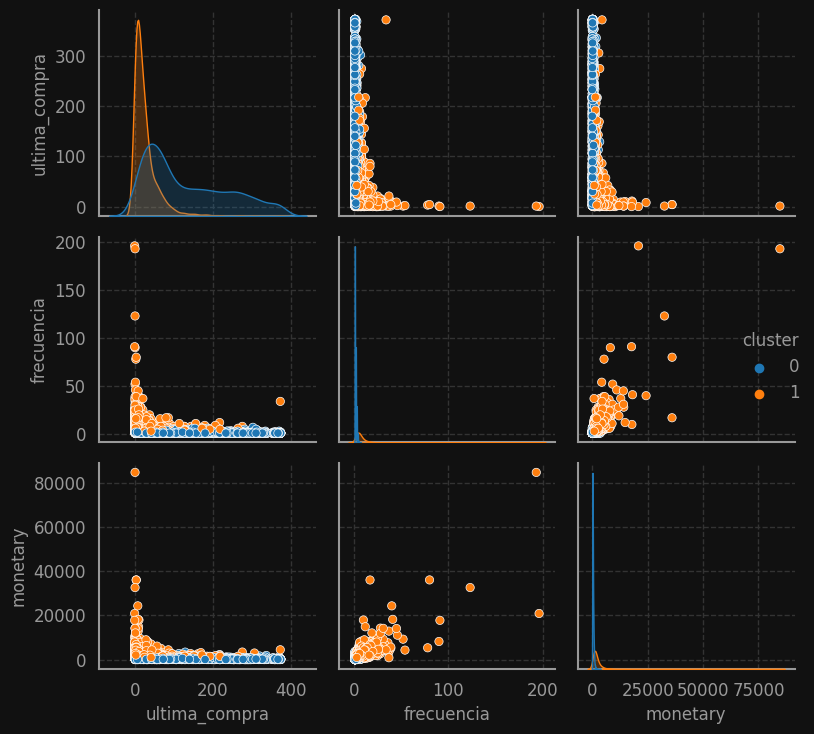

In [43]:
sns.pairplot(
    df_rfm[['ultima_compra', 'frecuencia', 'monetary', 'cluster']],
    hue='cluster',
    diag_kind='kde',
    palette='tab10',
    plot_kws={'alpha':1}
)
plt.tight_layout()
plt.show()

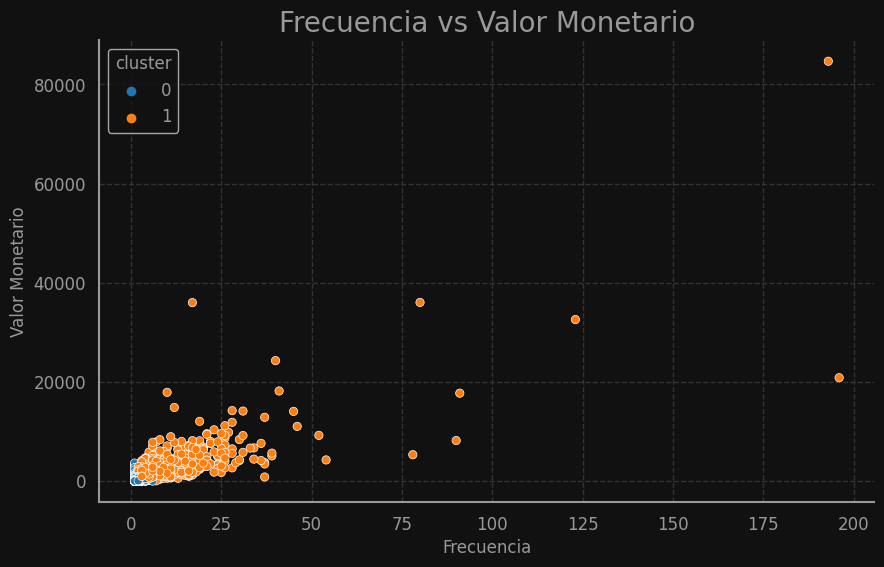

In [44]:
# Gráfico de dispersión para Frecuencia vs. Valor Monetario
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frecuencia', y='monetary', hue='cluster', data=df_rfm, palette='tab10')
plt.title('Frecuencia vs Valor Monetario')
plt.xlabel('Frecuencia')
plt.ylabel('Valor Monetario')
plt.show()

In [45]:
clusters_original = df_rfm.groupby('cluster')[['ultima_compra', 'frecuencia', 'monetary']].mean()
print(clusters_original)

         ultima_compra  frecuencia     monetary
cluster                                        
0           133.684087    1.607644   328.275910
1            26.362239    7.809348  2129.986999


In [46]:
resumen_estadistico = df_rfm.groupby('cluster')[['ultima_compra']].agg(u_max=('ultima_compra', 'max'), u_min=('ultima_compra', 'min'),u_mean=('ultima_compra', 'mean'), u_median=('ultima_compra', 'median'), u_std=('ultima_compra', 'std'),  u_ske=('ultima_compra', 'skew'), u_q25=('ultima_compra', lambda x: x.quantile(0.25)),  u_q75=('ultima_compra', lambda x: x.quantile(0.75))).round(2)
print(resumen_estadistico)

resumen_estadistico = df_rfm.groupby('cluster')[['frecuencia']].agg(f_max=('frecuencia', 'max'), f_min=('frecuencia', 'min'),  f_sum=('frecuencia', 'sum'), f_mean=('frecuencia', 'mean'), f_median=('frecuencia', 'median'),  f_ske=('frecuencia', 'skew'), f_std=('frecuencia', 'std'), f_q25=('frecuencia', lambda x: x.quantile(0.25)),  f_q75=('frecuencia', lambda x: x.quantile(0.75))).round(2)
print(resumen_estadistico)

resumen_estadistico = df_rfm.groupby('cluster')[['monetary']].agg(m_max=('monetary', 'max'), m_min=('monetary', 'min'), m_sum=('monetary', 'sum'), m_mean=('monetary', 'mean'), m_median=('monetary', 'median'), m_std=('monetary', 'std'), m_ske=('monetary', 'skew'), m_q25=('monetary', lambda x: x.quantile(0.25)),  m_q75=('monetary', lambda x: x.quantile(0.75))).round(2)
print(resumen_estadistico)


         u_max  u_min  u_mean  u_median   u_std  u_ske  u_q25   u_q75
cluster                                                              
0          373      1  133.68      95.0  105.59   0.68   45.0  215.00
1          372      0   26.36      16.0   33.15   3.39    7.0   32.75
         f_max  f_min  f_sum  f_mean  f_median  f_ske  f_std  f_q25  f_q75
cluster                                                                   
0            7      1   4122    1.61       1.0   1.53   0.85    1.0    2.0
1          196      1  12698    7.81       5.0  10.33  10.11    4.0    9.0
            m_max  m_min       m_sum   m_mean  m_median    m_std  m_ske  \
cluster                                                                   
0         3659.97   1.90   841699.43   328.28    256.14   285.16   2.87   
1        84673.78  99.92  3463358.86  2129.99   1427.74  3211.38  13.40   

          m_q25    m_q75  
cluster                   
0        135.23   429.74  
1        860.70  2397.50  


In [47]:
cluster_clientes = df_rfm.groupby('cluster').size().rename('n_cliente')
cluster_ventas = df_rfm.groupby('cluster')['monetary'].sum().rename('montos_totales')
cluster_frecuencia_compras = df_rfm.groupby('cluster')['frecuencia'].sum().rename('compras')

kpi = pd.concat([cluster_clientes, cluster_ventas, cluster_frecuencia_compras], axis=1).reset_index()

total_clientes = kpi['n_cliente'].sum()
total_ventas = kpi['montos_totales'].sum()
total_compras = kpi['compras'].sum()

kpi['Clientes'] = (kpi['n_cliente']/total_clientes)*100
kpi['Ventas'] = (kpi['montos_totales']/total_ventas)*100
kpi['Compras'] = (kpi['compras']/total_compras)*100


kpi['gastos_promedios'] = kpi['montos_totales']/ kpi['n_cliente']

print(kpi)

   cluster  n_cliente  montos_totales  compras   Clientes     Ventas  \
0        0       2564      841699.433     4122  61.193317  19.551406   
1        1       1626     3463358.861    12698  38.806683  80.448594   

    Compras  gastos_promedios  
0  24.50654        328.275910  
1  75.49346       2129.986999  


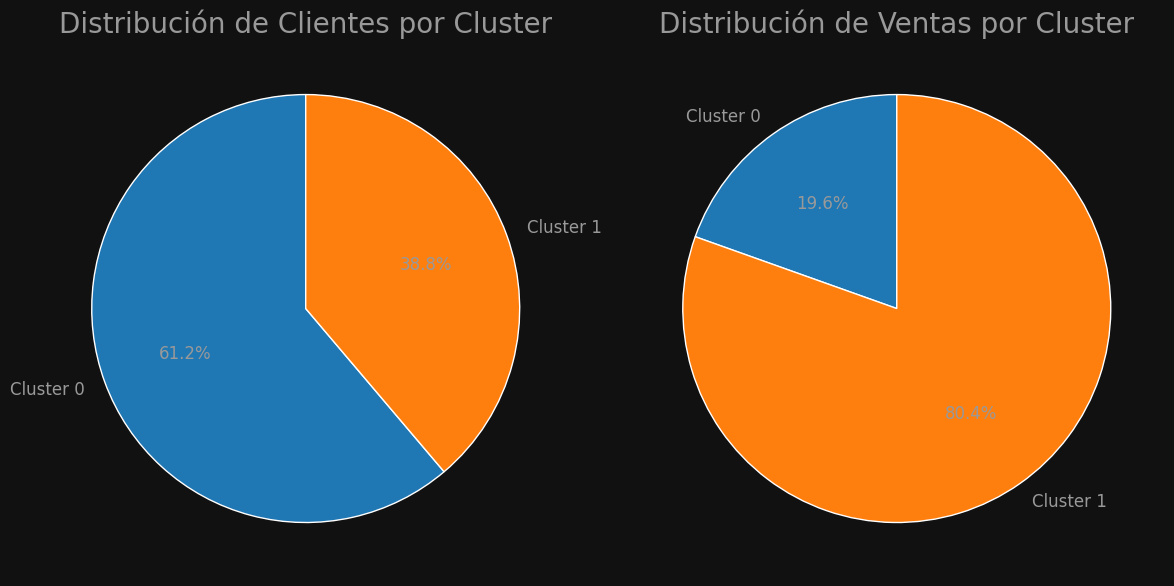

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Clientes
axes[0].pie(
    kpi['Clientes'], 
    labels=[f'Cluster {i}' for i in kpi['cluster']], 
    autopct='%1.1f%%',
    colors=['tab:blue', 'tab:orange'],
    startangle=90
)
axes[0].set_title('Distribución de Clientes por Cluster')

# Ventas
axes[1].pie(
    kpi['Ventas'], 
    labels=[f'Cluster {i}' for i in kpi['cluster']], 
    autopct='%1.1f%%',
    colors=['tab:blue', 'tab:orange'],
    startangle=90
)
axes[1].set_title('Distribución de Ventas por Cluster')

plt.tight_layout()
plt.show()


## Conclusion enfoque uno
* A partir del análisis RFM y la segmentación con K-Means, se identificaron dos tipos principales de clientes:
Cluster 1 (naranja): Clientes VIP que gastan más y compran con mayor frecuencia.
Cluster 0 (azul): Mezcla de clientes habituales, exclientes y casos con compras esporádicas o reintegros.
* Clientes VIP (38.8% de la base) → Generan aproximadamente el 80% de las ventas y el 75% de la frecuencia de compra. Se recomienda focalizar estrategias de retención y fidelización en este grupo, como programas de recompensas, descuentos exclusivos y acceso anticipado a productos.
* Clientes habituales (38% de la base) → Aportan solo el 19.5% de las ventas. No se sugiere aumentar significativamente la inversión en este segmento, pero sí implementar planes de reactivación (por ejemplo, campañas de email marketing segmentado o promociones especiales) para incentivar su regreso.

## Enfoque 2: por fecha (Sección en desarrollo, se implementara en la proxima version)

In [48]:
df_full_ventas['TotalPrice'] = df_full_ventas['Quantity'] * df_full_ventas['UnitPrice']

df_full_ventas['year'] = df_full_ventas['InvoiceDate'].dt.year
df_full_ventas['month'] = df_full_ventas['InvoiceDate'].dt.month
df_full_ventas['day'] = df_full_ventas['InvoiceDate'].dt.day
df_full_ventas['day_of_week'] = df_full_ventas['InvoiceDate'].dt.dayofweek

In [49]:
df_ventas_mensuales = df_full_ventas.groupby(['month', 'year'])['TotalPrice'].sum().reset_index()
df_ventas_mensuales.head()

,month,year,TotalPrice
0,1,2011,283460.910
1,2,2011,242464.940
2,3,2011,316345.030
3,4,2011,255401.421
4,5,2011,353696.090


In [50]:
df_ventas_mensuales['month_year'] = pd.to_datetime(df_ventas_mensuales['year'].astype(str) + '-' + df_ventas_mensuales['month'].astype(str))


<Axes: xlabel='month_year', ylabel='TotalPrice'>

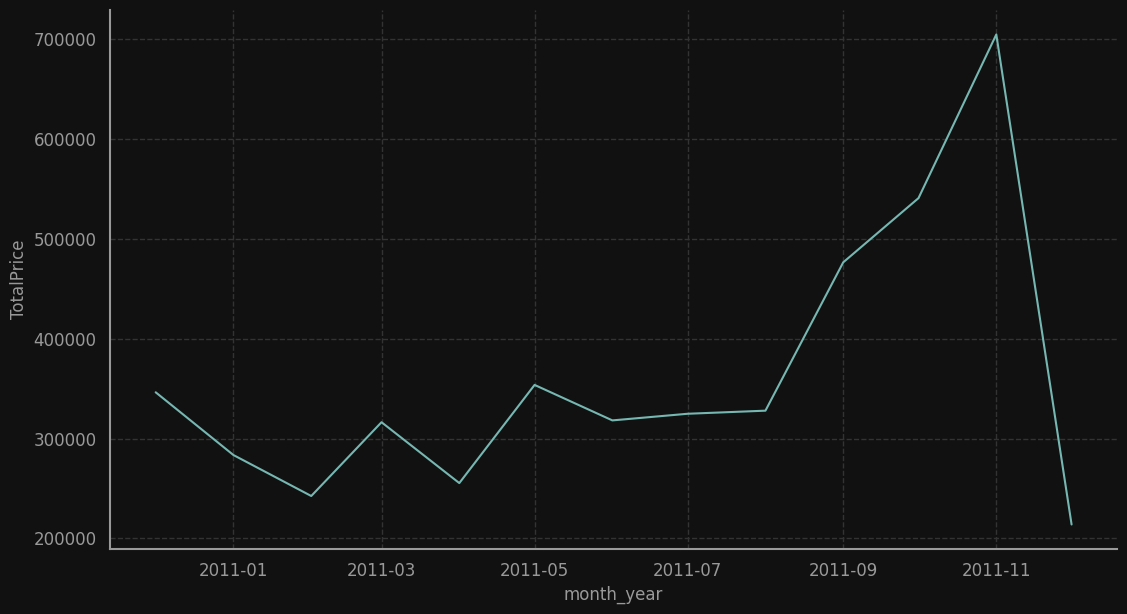

In [51]:
sns.lineplot(x='month_year', y='TotalPrice', data=df_ventas_mensuales)

## Enfoque 3: analisis por paises (Sección en desarrollo, se implementara en la proxima version)

In [52]:
df_ventas_por_pais = df_full_ventas.groupby('Country').agg(
    VentasTotales=('TotalPrice', 'sum'),
    CantidadProductos=('Quantity', 'sum'),
    NumeroTransacciones=('InvoiceNo', 'nunique'),
    NumeroClientes=('CustomerID', 'nunique')
).reset_index()

df_ventas_por_pais = df_ventas_por_pais.sort_values(by='VentasTotales', ascending=False)

print("Ventas totales y otras métricas por país:")
print(df_ventas_por_pais.head())


Ventas totales y otras métricas por país:
           Country  VentasTotales  CantidadProductos  NumeroTransacciones  \
36  United Kingdom    4148025.764            1893082                16181   
14         Germany     122633.750              60501                  420   
13          France     106102.730              54435                  361   
10            EIRE     102791.060              45578                  258   
31           Spain      26714.310              12966                   80   

    NumeroClientes  
36            3761  
14              91  
13              86  
10               3  
31              29  
